## Analyzing ALIGNN model in iteration 1 of active learning


In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from ipywidgets import interact, IntSlider, Checkbox, Dropdown, FloatSlider, fixed
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_kernels
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize
from scipy.linalg import eigh
import umap
from util.general import flatten_and_vstack, create_selectors
from util.landscape_processing import restore_to_square_shape
from util.plot import plot_loss_landscape, visualize_image_clusters, plot_categorical_data, plot_numerical_data, plot_umap_parameter_grid, plot_umap_scatter, plot_twin_umap_scatter
from src.pca_analysis import visualize_top_pcs, plot_pairwise_pc, plot_explained_variance
from src.spectral_clustering import manual_spectral_clustering
from sklearn.metrics import mutual_info_score
from sklearn.cluster import SpectralClustering
import seaborn as sns
import os

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

Load data from the folder

In [3]:
folders = [r'computed_loss_landscapes\fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error']

In [4]:
loss_function_dicts = []
for folder in folders:
    with open(os.path.join(folder,'processed_loss_function_dict.pkl'), 'rb') as file:
        loss_function_dicts.append(pickle.load(file))


# Merge all dictionaries from loss_function_dicts into a single dictionary
merged_loss_function_dict = {}
for d in loss_function_dicts:
    for key, value in d.items():
        if key not in merged_loss_function_dict:
            merged_loss_function_dict[key] = value
        else:
            # If key exists, update/append values
            merged_loss_function_dict[key].update(value)

# Update the loss_function_dict to use merged version
loss_function_dict = merged_loss_function_dict

In [5]:

with open(os.path.join(folders[0],'feat_sample_df.pkl'), 'rb') as file:
    feat_sample_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_composition_df.pkl'), 'rb') as file:
    feat_sample_composition_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_structure_df.pkl'), 'rb') as file:
    feat_sample_structure_df = pickle.load(file)

sample_dict = {
    'feat_sample_df': feat_sample_df,
    'feat_sample_composition_df': feat_sample_composition_df,
    'feat_sample_structure_df': feat_sample_structure_df}

combined_dict = {**sample_dict, **loss_function_dict}

In [7]:
# Load dataframes and extract jids
added_after_iter1_jids = pd.read_pickle("data/subset/added_after_iter1/added_after_iter1.pkl")['jid'].values
lowest_250_z_scores_jids = pd.read_pickle(r"data\subset\low_err_sample_for_active_learning_models\iter_1_alignn_1_lowest_250_error\alignn_1_1_lowest_250_z_scores.pkl")['jid'].values
iter1_train_jids = pd.read_pickle("data/subset/iter1_train/iter1_train.pkl")['jid'].values
all_data_jids = combined_dict['feat_sample_df']['jid'].values

### Parity plot for 3 alignn models

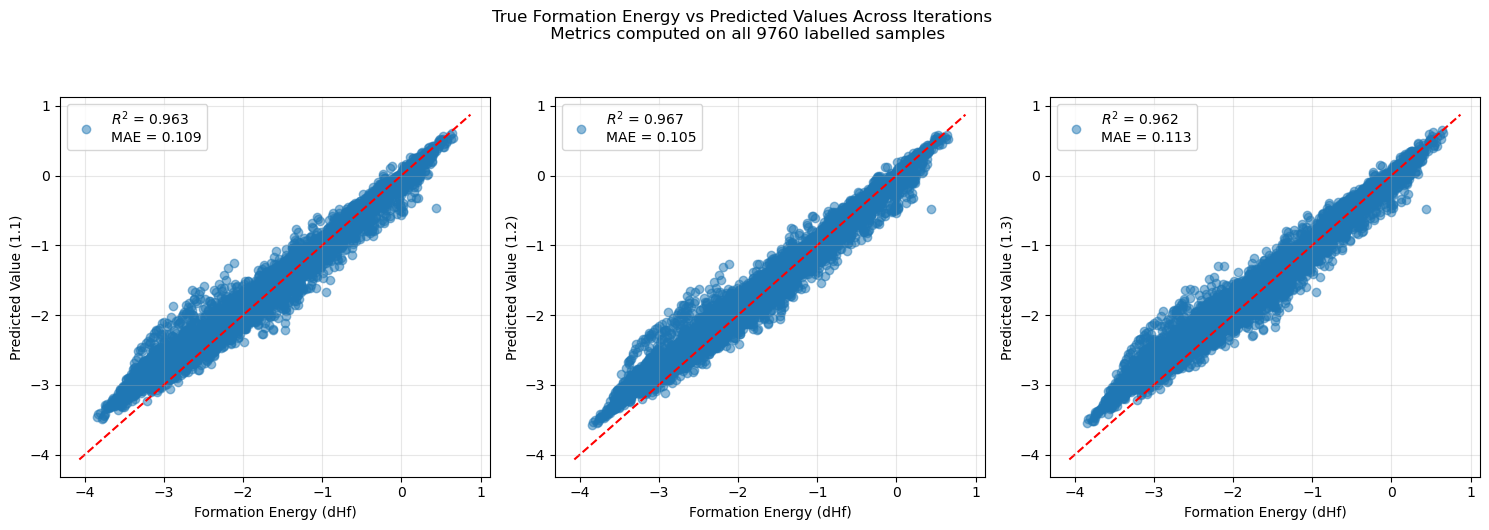

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare data
true_vals = combined_dict['feat_sample_df']['dHf'].values
preds_1 = combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values
preds_2 = combined_dict['feat_sample_df']['pred_val_alignn_1_2'].values
preds_3 = combined_dict['feat_sample_df']['pred_val_alignn_1_3'].values

# Compute metrics
r2_1 = r2_score(true_vals, preds_1)
mae_1 = mean_absolute_error(true_vals, preds_1)
r2_2 = r2_score(true_vals, preds_2)
mae_2 = mean_absolute_error(true_vals, preds_2)
r2_3 = r2_score(true_vals, preds_3)
mae_3 = mean_absolute_error(true_vals, preds_3)

# Create figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1.1 predictions
sc1 = ax1.scatter(true_vals, preds_1, alpha=0.5)
lims1 = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  
    np.max([ax1.get_xlim(), ax1.get_ylim()])
]
ax1.plot(lims1, lims1, 'r--', alpha=1, zorder=1)
ax1.set_xlabel('Formation Energy (dHf)')
ax1.set_ylabel('Predicted Value (1.1)')
ax1.grid(True, alpha=0.3)
ax1.legend([f"$R^2$ = {r2_1:.3f}\nMAE = {mae_1:.3f}"], loc='upper left', frameon=True)

# Plot 1.2 predictions
sc2 = ax2.scatter(true_vals, preds_2, alpha=0.5)
lims2 = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  
    np.max([ax2.get_xlim(), ax2.get_ylim()])
]
ax2.plot(lims2, lims2, 'r--', alpha=1, zorder=1)
ax2.set_xlabel('Formation Energy (dHf)')
ax2.set_ylabel('Predicted Value (1.2)')
ax2.grid(True, alpha=0.3)
ax2.legend([f"$R^2$ = {r2_2:.3f}\nMAE = {mae_2:.3f}"], loc='upper left', frameon=True)

# Plot 1.3 predictions
sc3 = ax3.scatter(true_vals, preds_3, alpha=0.5)
lims3 = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  
    np.max([ax3.get_xlim(), ax3.get_ylim()])
]
ax3.plot(lims3, lims3, 'r--', alpha=1, zorder=1)
ax3.set_xlabel('Formation Energy (dHf)')
ax3.set_ylabel('Predicted Value (1.3)')
ax3.grid(True, alpha=0.3)
ax3.legend([f"$R^2$ = {r2_3:.3f}\nMAE = {mae_3:.3f}"], loc='upper left', frameon=True)

plt.suptitle('True Formation Energy vs Predicted Values Across Iterations \n Metrics computed on all 9760 labelled samples', y=1.05)
plt.tight_layout()
plt.show()


### Manual labelling and std

In [10]:
# Create a list of 'Other' labels for all data points
all_data_jids = combined_dict['feat_sample_df']['jid'].values
labels = ['Other'] * len(all_data_jids)

# Change labels for samples added after iter 1 to 'Iter 1 QBC'
for i, jid in enumerate(all_data_jids):
    if jid in added_after_iter1_jids:
        labels[i] = 'Iter 1 QBC'
    elif jid in iter1_train_jids:
        labels[i] = 'Iter 1 Train'
    elif jid in lowest_250_z_scores_jids:
        labels[i] = 'Lowest error'

# Convert to numpy array
manual_labels = np.array(labels)


# Calculate standard deviation between predictions from different iterations
pred_cols = ['pred_val_alignn_1_1', 'pred_val_alignn_1_2', 'pred_val_alignn_1_3']
combined_dict['feat_sample_df']['std_pred_alignn_1'] = combined_dict['feat_sample_df'][pred_cols].std(axis=1)

# Display first few rows including the new std column
std = combined_dict['feat_sample_df']['std_pred_alignn_1'].copy().to_list()

### Preliminary histogram visualization

Get information about
1. Iter 1 training set
2. Iter 1 QBC
3. 250 samples used for eigenvector computation


Iter 1 QBC Statistics:
Count: 1199
Pred: mean=-1.978, std=0.852, min=-3.461, max=0.523
AbsErr: mean=0.187, std=0.168, min=0.000, max=1.016
dHf: mean=-2.117, std=0.977, min=-3.844, max=0.490
Std: mean=0.035, std=0.024, min=0.001, max=0.123

Lowest 250 Statistics:
Count: 250
Pred: mean=-1.032, std=0.683, min=-2.944, max=0.528
AbsErr: mean=0.001, std=0.000, min=0.000, max=0.002
dHf: mean=-1.032, std=0.683, min=-2.945, max=0.528
Std: mean=0.017, std=0.014, min=0.000, max=0.108

Iter1 Train Statistics:
Count: 630
Pred: mean=-1.064, std=0.732, min=-3.225, max=0.497
AbsErr: mean=0.011, std=0.010, min=0.000, max=0.068
dHf: mean=-1.064, std=0.730, min=-3.209, max=0.484
Std: mean=0.010, std=0.006, min=0.000, max=0.050

All Data Statistics:
Count: 9760
Pred: mean=-1.350, std=0.811, min=-3.485, max=0.615
AbsErr: mean=0.109, std=0.134, min=0.000, max=1.016
dHf: mean=-1.389, std=0.895, min=-3.844, max=0.647
Std: mean=0.027, std=0.019, min=0.000, max=0.131

Overlaps between sets:
Added After Iter1 ∩

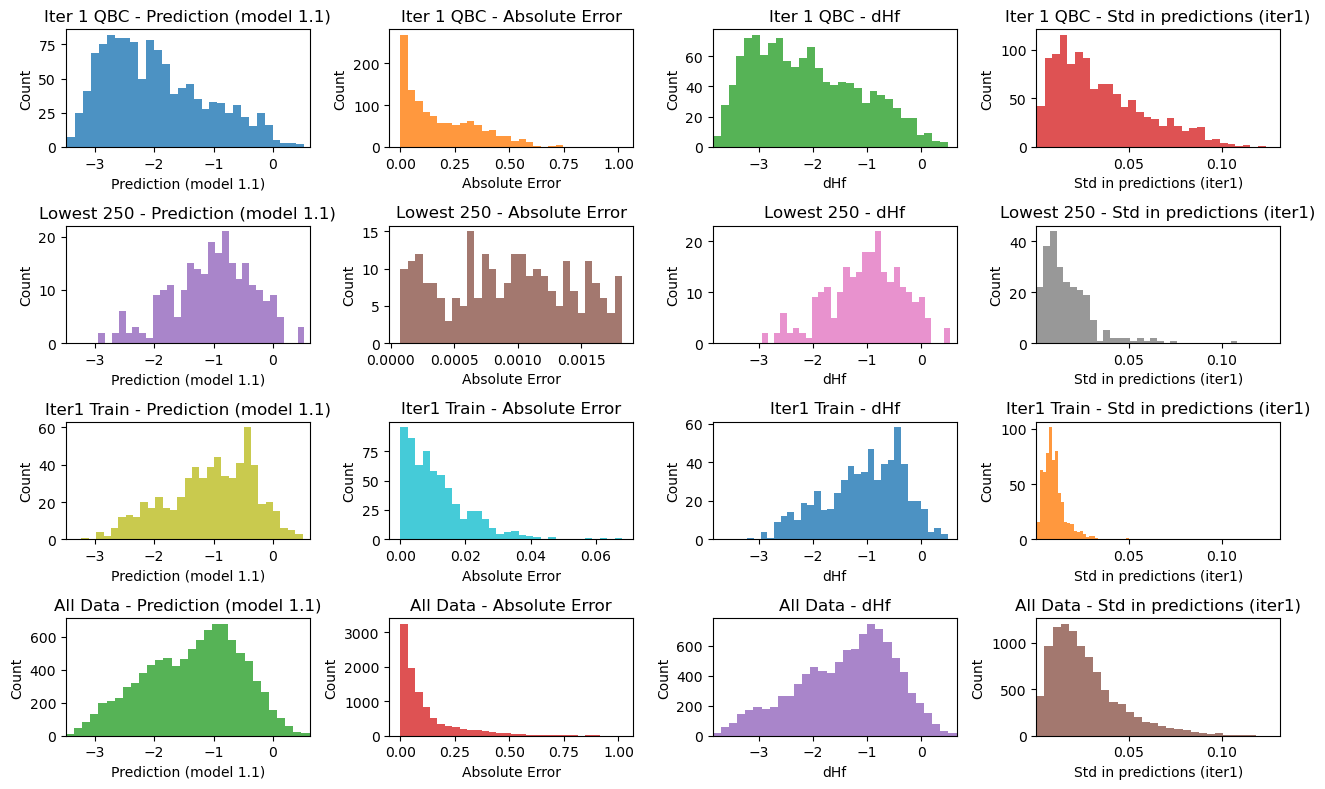

In [11]:
# Helper to get predictions, abs error, dHf, and std for a jid subset
def get_subset_data(jids):
    idx = np.isin(all_data_jids, jids)
    pred = combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values[idx]
    true = combined_dict['feat_sample_df']['dHf'].values[idx]
    std = combined_dict['feat_sample_df']['std_pred_alignn_1'].values[idx]
    return pred, np.abs(pred - true), true, std

# Gather data for each subset
subsets = {
    "Iter 1 QBC": get_subset_data(added_after_iter1_jids),
    "Lowest 250": get_subset_data(lowest_250_z_scores_jids),
    "Iter1 Train": get_subset_data(iter1_train_jids)
}

# Also get all data
all_pred = combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values
all_true = combined_dict['feat_sample_df']['dHf'].values
all_std = combined_dict['feat_sample_df']['std_pred_alignn_1'].values
all_err = np.abs(all_pred - all_true)
subsets_with_all = dict(subsets)
subsets_with_all["All Data"] = (all_pred, all_err, all_true, all_std)

# Print stats compactly, now including std
for name, (pred, err, dhf, std) in subsets_with_all.items():
    print(f"\n{name} Statistics:")
    print(f"Count: {len(pred)}")
    print(f"Pred: mean={np.mean(pred):.3f}, std={np.std(pred):.3f}, min={np.min(pred):.3f}, max={np.max(pred):.3f}")
    print(f"AbsErr: mean={np.mean(err):.3f}, std={np.std(err):.3f}, min={np.min(err):.3f}, max={np.max(err):.3f}")
    print(f"dHf: mean={np.mean(dhf):.3f}, std={np.std(dhf):.3f}, min={np.min(dhf):.3f}, max={np.max(dhf):.3f}")
    print(f"Std: mean={np.mean(std):.3f}, std={np.std(std):.3f}, min={np.min(std):.3f}, max={np.max(std):.3f}")

# Overlaps
print("\nOverlaps between sets:")
print(f"Added After Iter1 ∩ Lowest 250: {np.intersect1d(added_after_iter1_jids, lowest_250_z_scores_jids).size}")
print(f"Added After Iter1 ∩ Iter1 Train: {np.intersect1d(added_after_iter1_jids, iter1_train_jids).size}")
print(f"Lowest 250 ∩ Iter1 Train: {np.intersect1d(lowest_250_z_scores_jids, iter1_train_jids).size}")

# Plot 12 histograms: 4 subsets × 3 metrics (+ std)
fig, axes = plt.subplots(4, 4, figsize=(13, 8))
labels = ["Prediction (model 1.1)", "Absolute Error", "dHf", "Std in predictions (iter1)"]
subset_names = list(subsets.keys()) + ["All Data"]

# Determine x-axis ranges for each metric except Absolute Error
# Use all data for consistent axis limits
x_ranges = [
    (np.min(all_pred), np.max(all_pred)),   # Prediction
    None,                                   # Absolute Error (no fixed range)
    (np.min(all_true), np.max(all_true)),   # dHf
    (np.min(all_std), np.max(all_std))      # Std
]

for row, name in enumerate(subset_names):
    pred, err, dhf, std = subsets_with_all[name]
    for col, data in enumerate([pred, err, dhf, std]):
        ax = axes[row, col]
        ax.hist(data, bins=30, alpha=0.8, color=f'C{row*4+col}')
        ax.set_title(f"{name} - {labels[col]}")
        ax.set_xlabel(labels[col])
        ax.set_ylabel("Count")
        # Set xlim except for Absolute Error column (col==1)
        if x_ranges[col] is not None:
            ax.set_xlim(x_ranges[col])
plt.tight_layout()
plt.show()



Iter 1 QBC Statistics:
Count: 1199
Pred: mean=-1.978, std=0.852, min=-3.461, max=0.523
AbsErr: mean=0.187, std=0.168, min=0.000, max=1.016
dHf: mean=-2.117, std=0.977, min=-3.844, max=0.490
Std: mean=0.035, std=0.024, min=0.001, max=0.123

Lowest 250 Statistics:
Count: 250
Pred: mean=-1.032, std=0.683, min=-2.944, max=0.528
AbsErr: mean=0.001, std=0.000, min=0.000, max=0.002
dHf: mean=-1.032, std=0.683, min=-2.945, max=0.528
Std: mean=0.017, std=0.014, min=0.000, max=0.108

Iter1 Train Statistics:
Count: 630
Pred: mean=-1.064, std=0.732, min=-3.225, max=0.497
AbsErr: mean=0.011, std=0.010, min=0.000, max=0.068
dHf: mean=-1.064, std=0.730, min=-3.209, max=0.484
Std: mean=0.010, std=0.006, min=0.000, max=0.050

All Data Statistics:
Count: 9760
Pred: mean=-1.350, std=0.811, min=-3.485, max=0.615
AbsErr: mean=0.109, std=0.134, min=0.000, max=1.016
dHf: mean=-1.389, std=0.895, min=-3.844, max=0.647
Std: mean=0.027, std=0.019, min=0.000, max=0.131

Overlaps between sets:
Added After Iter1 ∩

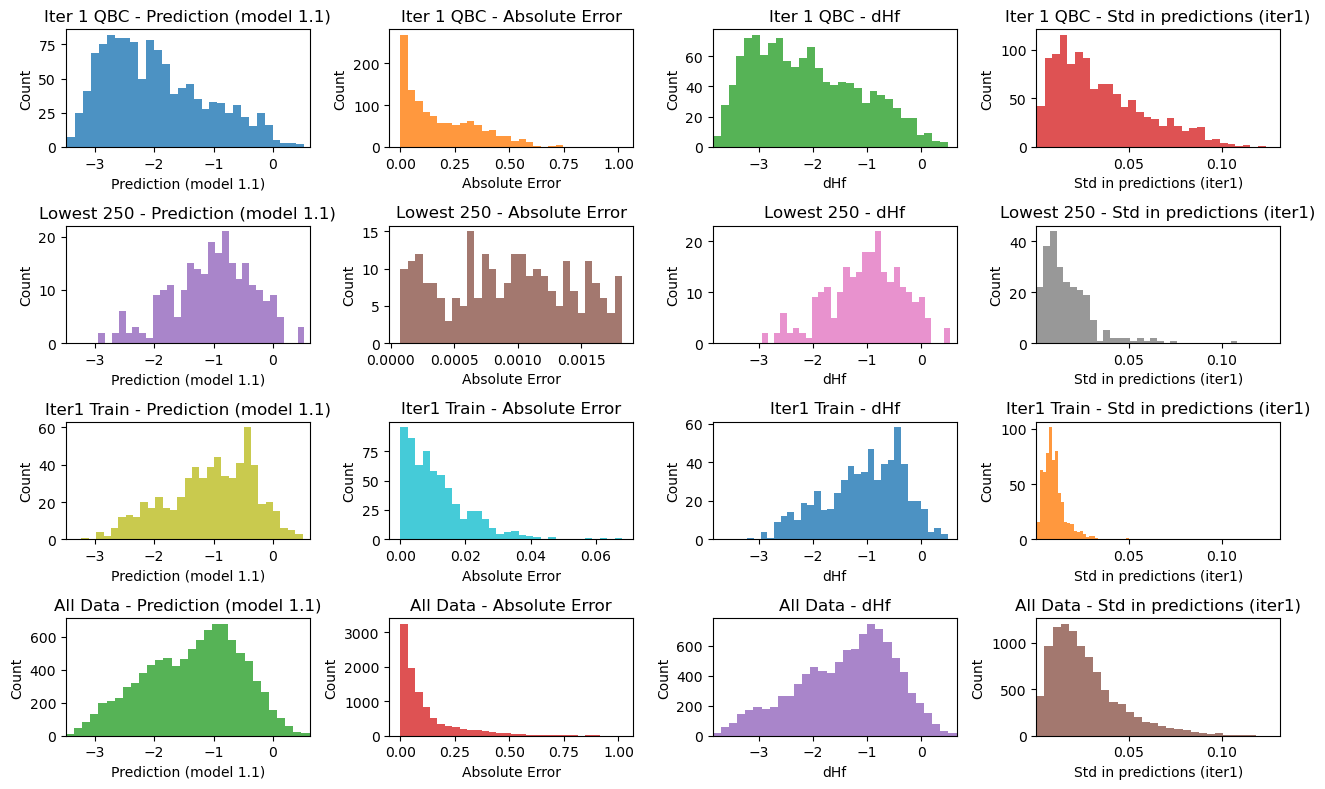

In [12]:
# Helper to get predictions, abs error, dHf, and std for a jid subset
def get_subset_data(jids):
    idx = np.isin(all_data_jids, jids)
    pred = combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values[idx]
    true = combined_dict['feat_sample_df']['dHf'].values[idx]
    std = combined_dict['feat_sample_df']['std_pred_alignn_1'].values[idx]
    return pred, np.abs(pred - true), true, std

# Gather data for each subset
subsets = {
    "Iter 1 QBC": get_subset_data(added_after_iter1_jids),
    "Lowest 250": get_subset_data(lowest_250_z_scores_jids),
    "Iter1 Train": get_subset_data(iter1_train_jids)
}

# Also get all data
all_pred = combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values
all_true = combined_dict['feat_sample_df']['dHf'].values
all_std = combined_dict['feat_sample_df']['std_pred_alignn_1'].values
all_err = np.abs(all_pred - all_true)
subsets_with_all = dict(subsets)
subsets_with_all["All Data"] = (all_pred, all_err, all_true, all_std)

# Print stats compactly, now including std
for name, (pred, err, dhf, std) in subsets_with_all.items():
    print(f"\n{name} Statistics:")
    print(f"Count: {len(pred)}")
    print(f"Pred: mean={np.mean(pred):.3f}, std={np.std(pred):.3f}, min={np.min(pred):.3f}, max={np.max(pred):.3f}")
    print(f"AbsErr: mean={np.mean(err):.3f}, std={np.std(err):.3f}, min={np.min(err):.3f}, max={np.max(err):.3f}")
    print(f"dHf: mean={np.mean(dhf):.3f}, std={np.std(dhf):.3f}, min={np.min(dhf):.3f}, max={np.max(dhf):.3f}")
    print(f"Std: mean={np.mean(std):.3f}, std={np.std(std):.3f}, min={np.min(std):.3f}, max={np.max(std):.3f}")

# Overlaps
print("\nOverlaps between sets:")
print(f"Added After Iter1 ∩ Lowest 250: {np.intersect1d(added_after_iter1_jids, lowest_250_z_scores_jids).size}")
print(f"Added After Iter1 ∩ Iter1 Train: {np.intersect1d(added_after_iter1_jids, iter1_train_jids).size}")
print(f"Lowest 250 ∩ Iter1 Train: {np.intersect1d(lowest_250_z_scores_jids, iter1_train_jids).size}")

# Plot 12 histograms: 4 subsets × 3 metrics (+ std)
fig, axes = plt.subplots(4, 4, figsize=(13, 8))
labels = ["Prediction (model 1.1)", "Absolute Error", "dHf", "Std in predictions (iter1)"]
subset_names = list(subsets.keys()) + ["All Data"]

# Determine x-axis ranges for each metric except Absolute Error
# Use all data for consistent axis limits
x_ranges = [
    (np.min(all_pred), np.max(all_pred)),   # Prediction
    None,                                   # Absolute Error (no fixed range)
    (np.min(all_true), np.max(all_true)),   # dHf
    (np.min(all_std), np.max(all_std))      # Std
]

for row, name in enumerate(subset_names):
    pred, err, dhf, std = subsets_with_all[name]
    for col, data in enumerate([pred, err, dhf, std]):
        ax = axes[row, col]
        ax.hist(data, bins=30, alpha=0.8, color=f'C{row*4+col}')
        ax.set_title(f"{name} - {labels[col]}")
        ax.set_xlabel(labels[col])
        ax.set_ylabel("Count")
        # Set xlim except for Absolute Error column (col==1)
        if x_ranges[col] is not None:
            ax.set_xlim(x_ranges[col])
plt.tight_layout()
plt.show()


Iter 1 QBC samples have distinct distribution in true dHf.

If the training set had an uniform distribution of true dHf, the performance may change.

### Pairwise plot on true value, err and std

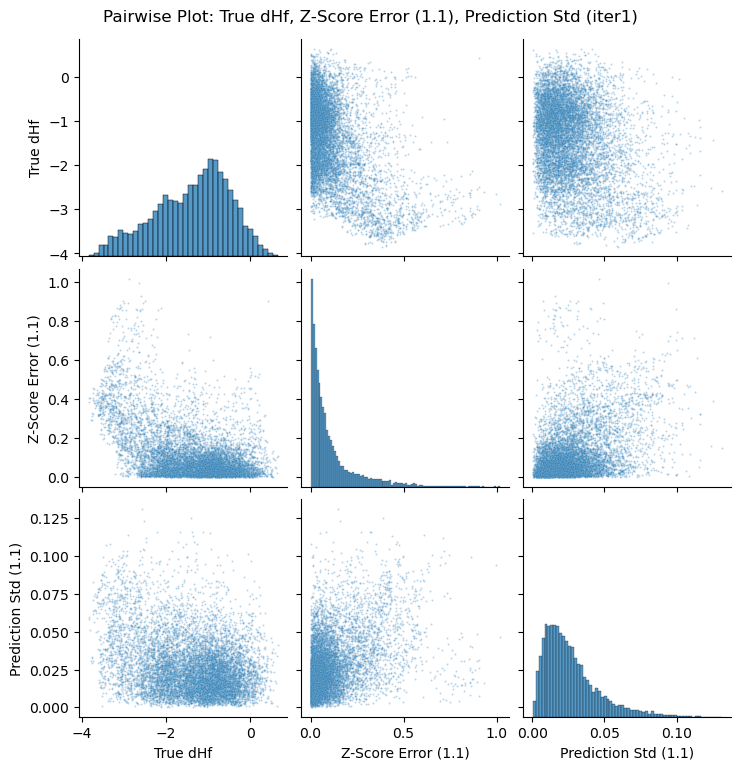

In [13]:
import seaborn as sns

# Prepare DataFrame for pairplot
df_pair = pd.DataFrame({
    'True dHf': combined_dict['feat_sample_df']['dHf'],
    'Z-Score Error (1.1)': combined_dict['feat_sample_df']['abs_err_alignn_1_1'],
    'Prediction Std (1.1)': std
})

# Plot pairwise relationships
sns.pairplot(df_pair, diag_kind='hist', plot_kws={'alpha': 0.3, 's': 2})
plt.suptitle('Pairwise Plot: True dHf, Z-Score Error (1.1), Prediction Std (iter1)', y=1.02)
plt.show()

### 3 average loss landscapes

C:\Users\EthanH24\AppData\Local\Temp\ipykernel_13376\1701203324.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_landscape = np.log(np.mean(arr[idx], axis=0))


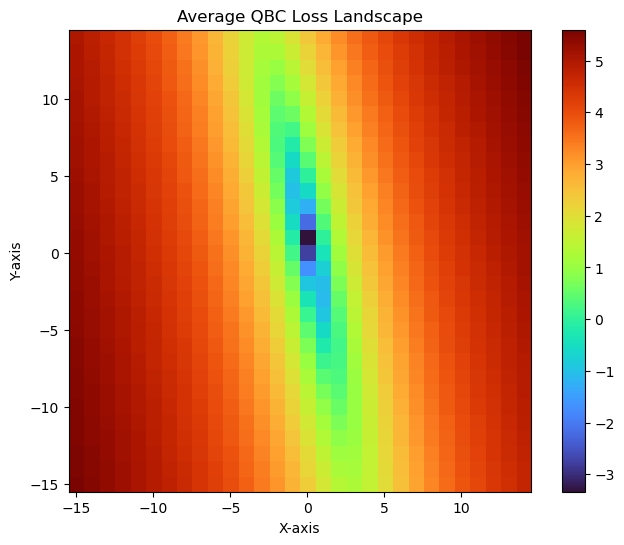

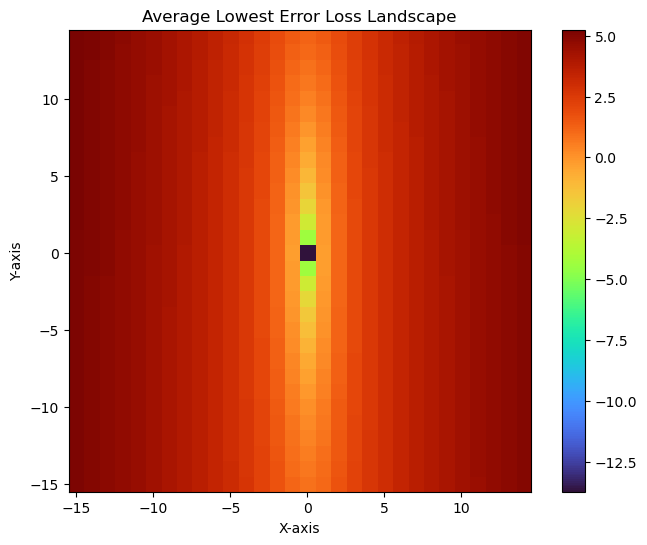

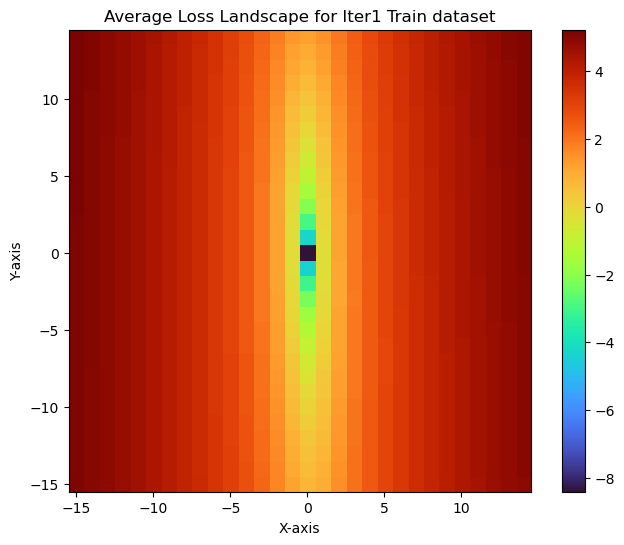

In [14]:
# Helper for average log-loss landscape plotting
def plot_avg_landscape(jids, title):
    idx = np.where(np.isin(all_data_jids, jids))[0]
    arr = loss_function_dict['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse']['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse_loss_landscape_array'].copy()
    avg_landscape = np.log(np.mean(arr[idx], axis=0))
    plot_loss_landscape(avg_landscape, title=title, color_scale='turbo')

plot_avg_landscape(added_after_iter1_jids, 'Average QBC Loss Landscape')
plot_avg_landscape(lowest_250_z_scores_jids, 'Average Lowest Error Loss Landscape')
plot_avg_landscape(iter1_train_jids, 'Average Loss Landscape for Iter1 Train dataset')


### True dHf vs error, colored with std

Generate plot on all data.

C:\Users\EthanH24\AppData\Local\Temp\ipykernel_13376\1281701238.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = matplotlib.cm.get_cmap('tab20', len(unique_manual_labels))
C:\Users\EthanH24\AppData\Local\Temp\ipykernel_13376\1281701238.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


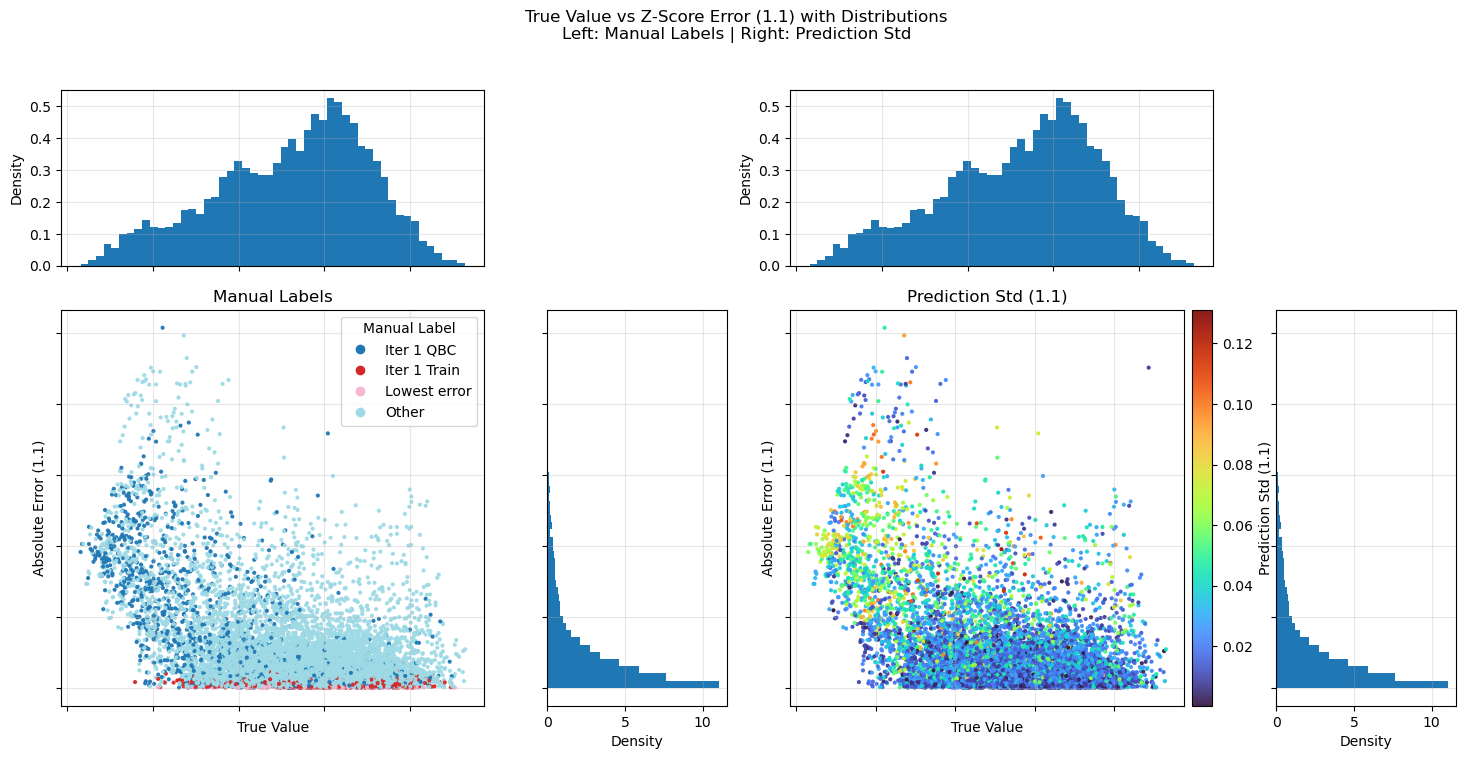

In [15]:
s=4

# Prepare color mapping for manual labels
unique_manual_labels = np.unique(manual_labels)
cmap_labels = matplotlib.cm.get_cmap('tab20', len(unique_manual_labels))
label_to_color = {label: cmap_labels(i) for i, label in enumerate(unique_manual_labels)}
point_colors = [label_to_color[label] for label in manual_labels]

# Use standard deviation as color (continuous)
std_values = std

fig = plt.figure(figsize=(18, 8))
gs = plt.GridSpec(3, 6, figure=fig, wspace=0.35, hspace=0.25)

# --- LEFT: Manual label coloring ---
# Scatter
ax_scatter_left = fig.add_subplot(gs[1:, 0:2])
sc_left = ax_scatter_left.scatter(
    combined_dict['feat_sample_df']['dHf'],
    combined_dict['feat_sample_df']['abs_err_alignn_1_1'],
    alpha=0.9,
    c=point_colors, s=s
)
ax_scatter_left.set_xlabel('True Value')
ax_scatter_left.set_ylabel('Absolute Error (1.1)')
ax_scatter_left.grid(True, alpha=0.3)

# Legend for manual_labels
handles = [
    Line2D([0], [0], marker='o', color='w', label=str(label),
           markerfacecolor=label_to_color[label], markersize=8)
    for label in unique_manual_labels
]
ax_scatter_left.legend(handles=handles, title='Manual Label', loc='upper right', bbox_to_anchor=(1, 1))

# X histogram
ax_histx_left = fig.add_subplot(gs[0, 0:2], sharex=ax_scatter_left)
ax_histx_left.hist(combined_dict['feat_sample_df']['dHf'],
                   bins=50, density=True)
ax_histx_left.grid(True, alpha=0.3)
ax_histx_left.set_xticklabels([])
ax_histx_left.set_ylabel('Density')  # Label for density

# Y histogram
ax_histy_left = fig.add_subplot(gs[1:, 2], sharey=ax_scatter_left)
ax_histy_left.hist(combined_dict['feat_sample_df']['abs_err_alignn_1_1'],
                   bins=50, orientation='horizontal', density=True)
ax_histy_left.grid(True, alpha=0.3)
ax_histy_left.set_yticklabels([])
ax_histy_left.set_xlabel('Density')  # Label for density

ax_scatter_left.set_title('Manual Labels')

# --- RIGHT: Std colormap coloring ---
# Scatter
ax_scatter_right = fig.add_subplot(gs[1:, 3:5])
sc_right = ax_scatter_right.scatter(
    combined_dict['feat_sample_df']['dHf'],
    combined_dict['feat_sample_df']['abs_err_alignn_1_1'],
    alpha=0.9,
    c=std_values,
    cmap='turbo', s=s
)
ax_scatter_right.set_xlabel('True Value')
ax_scatter_right.set_ylabel('Absolute Error (1.1)')
ax_scatter_right.grid(True, alpha=0.3)

# Colorbar for std
cbar = plt.colorbar(sc_right, ax=ax_scatter_right, pad=0.02, fraction=0.05)
cbar.set_label('Prediction Std (1.1)')

# X histogram
ax_histx_right = fig.add_subplot(gs[0, 3:5], sharex=ax_scatter_right)
ax_histx_right.hist(combined_dict['feat_sample_df']['dHf'],
                    bins=50, density=True)
ax_histx_right.grid(True, alpha=0.3)
ax_histx_right.set_xticklabels([])
ax_histx_right.set_ylabel('Density')  # Label for density

# Y histogram
ax_histy_right = fig.add_subplot(gs[1:, 5], sharey=ax_scatter_right)
ax_histy_right.hist(combined_dict['feat_sample_df']['abs_err_alignn_1_1'],
                    bins=50, orientation='horizontal', density=True)
ax_histy_right.grid(True, alpha=0.3)
ax_histy_right.set_yticklabels([])
ax_histy_right.set_xlabel('Density')  # Label for density

ax_scatter_right.set_title('Prediction Std (1.1)')

plt.suptitle('True Value vs Z-Score Error (1.1) with Distributions\nLeft: Manual Labels | Right: Prediction Std', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### UMAP on Log Loss landscapes

In [16]:
# Retrieve the selected loss landscape array using the chosen selectors
log_loss_landscape_array = loss_function_dict['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse']['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse_log_loss_landscape_array'].copy()

# Set UMAP hyperparameters for dimensionality reduction
n_neighbors, min_dist = 15, 0.1

# Initialize UMAP with the specified hyperparameters and a fixed random state for reproducibility
umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)

# Apply UMAP to fit and transform the flattened landscape array data
umap_transformed_data = umap_reducer.fit_transform(flatten_and_vstack(log_loss_landscape_array))

c:\Users\EthanH24\anaconda3\envs\ACSURP\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


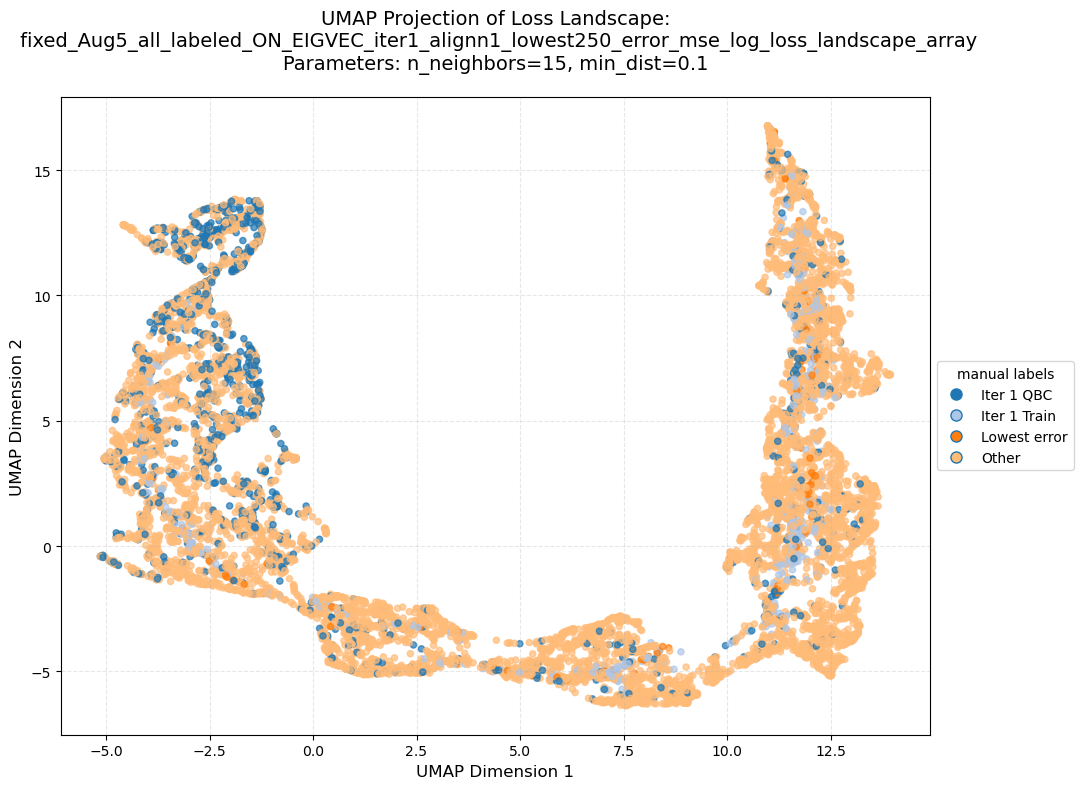

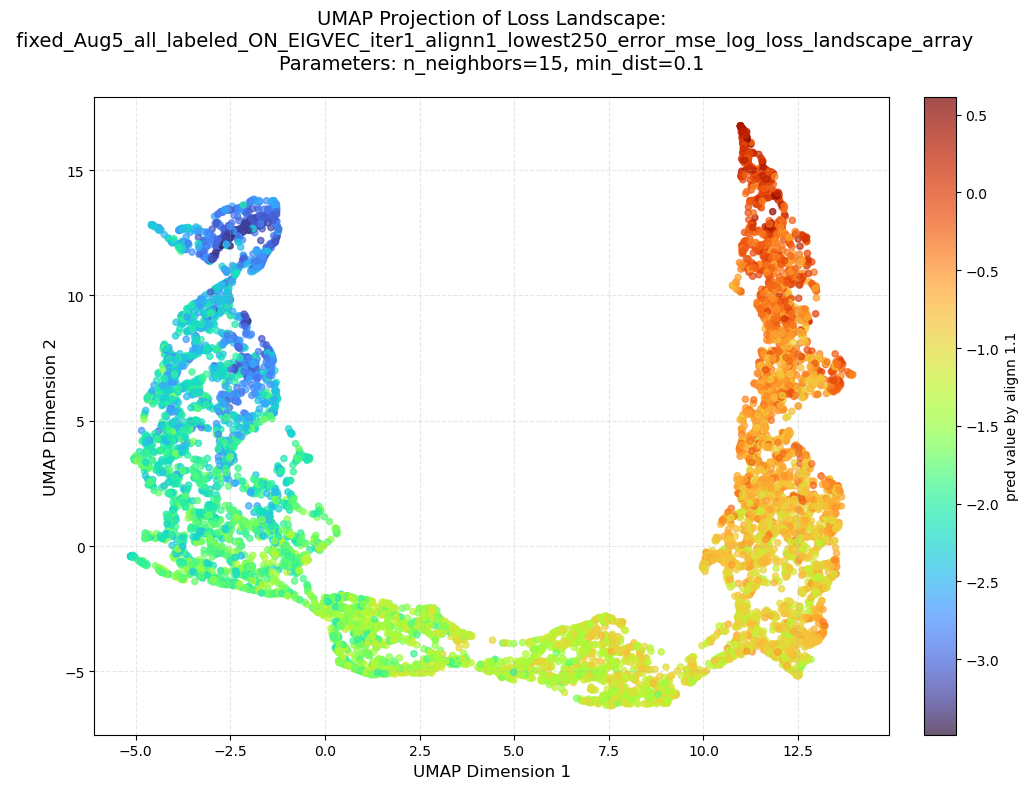

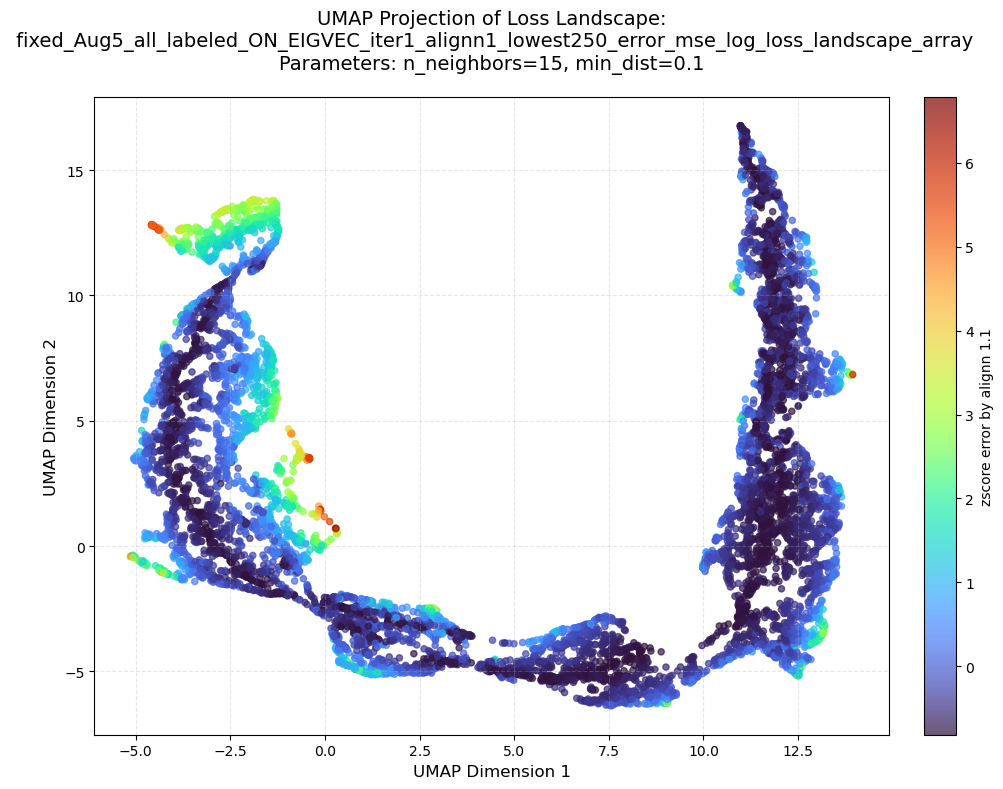

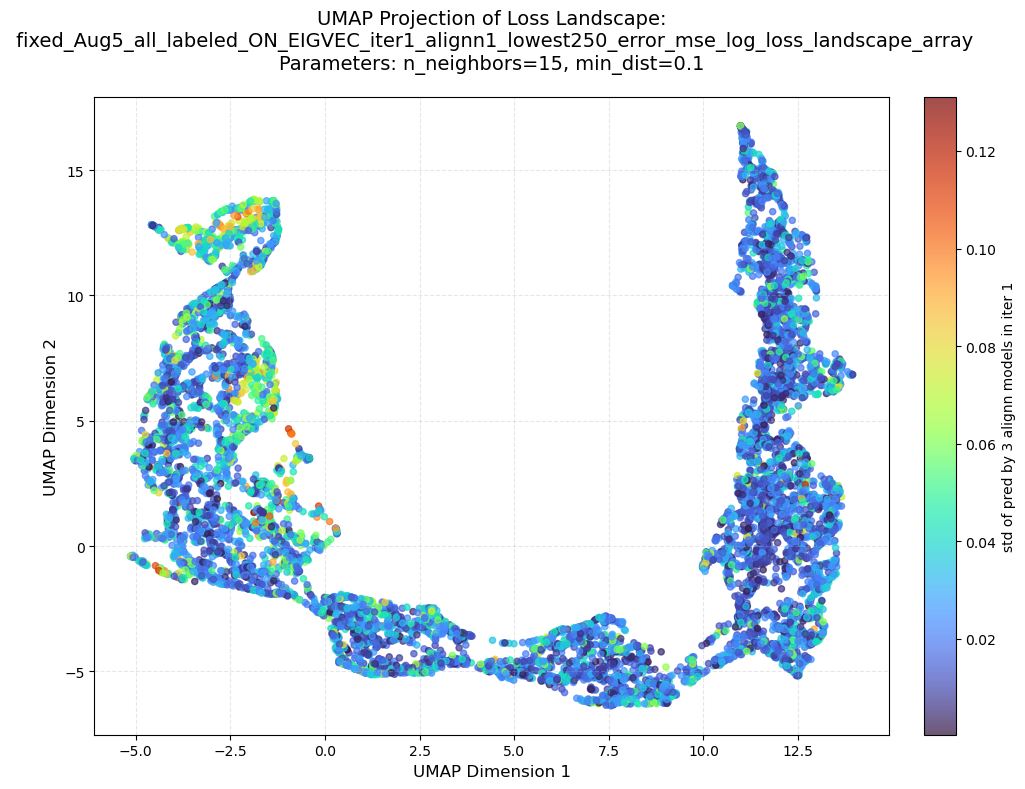

In [17]:
plot_umap_scatter(umap_transformed_data, label_name='manual labels',label_type='categorical',labels=manual_labels,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)
plot_umap_scatter(umap_transformed_data, label_name='pred value by alignn 1.1',label_type='continuous',labels=combined_dict['feat_sample_df']['pred_val_alignn_1_1'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)
plot_umap_scatter(umap_transformed_data, label_name='zscore error by alignn 1.1',label_type='continuous',labels=combined_dict['feat_sample_df']['z_score_err_alignn_1_1'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)
plot_umap_scatter(umap_transformed_data, label_name='std of pred by 3 alignn models in iter 1',label_type='continuous',labels=combined_dict['feat_sample_df']['std_pred_alignn_1'].values,n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

### K-means showed on UMAP

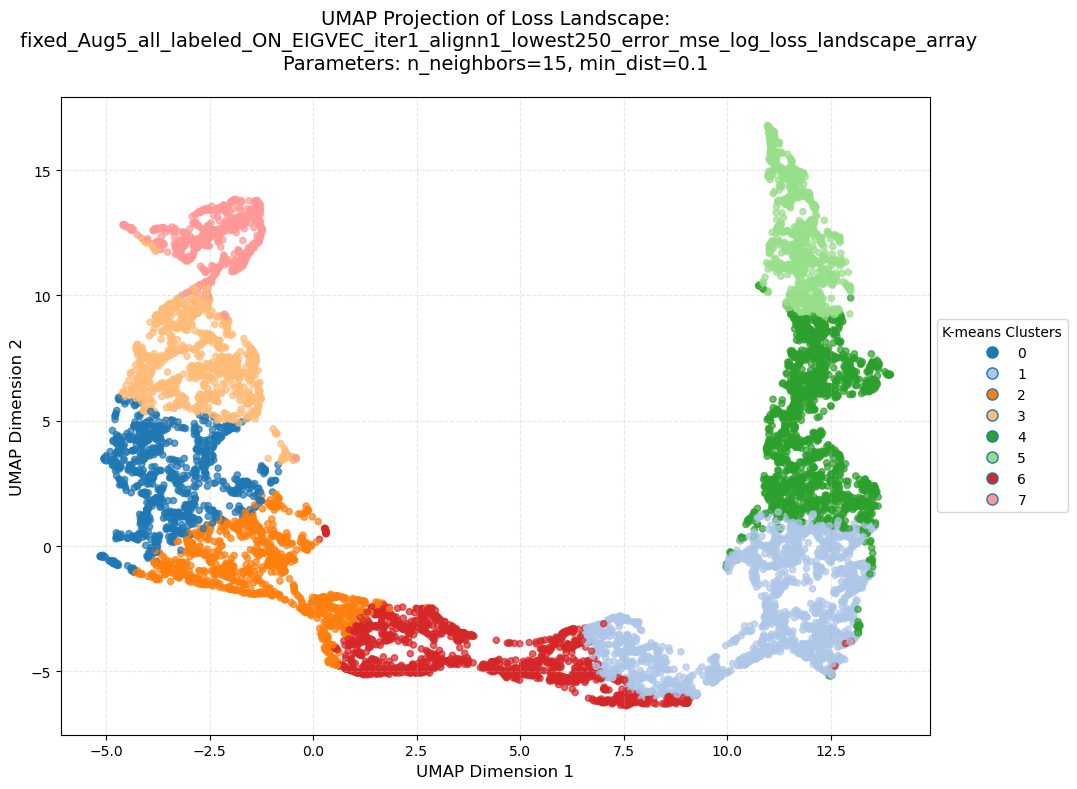

In [18]:
# Initialize and fit K-means clustering with the specified number of clusters
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(flatten_and_vstack(log_loss_landscape_array))
# Retrieve the cluster labels from the fitted K-means model
k_means_labels = kmeans.labels_
plot_umap_scatter(umap_transformed_data, labels=k_means_labels, label_name='K-means Clusters', label_type='categorical', n_neighbors=n_neighbors, min_dist=min_dist, landscape_array=log_loss_landscape_array)

### Selected per sample loss landscapes

c:\Users\EthanH24\Desktop\2025 Summer\2025Summer-ACSURP\util\plot.py:226: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_arrays = [arrays[i][:, :, 0] for i in selected_indices]  # Convert 3D arrays to 2D


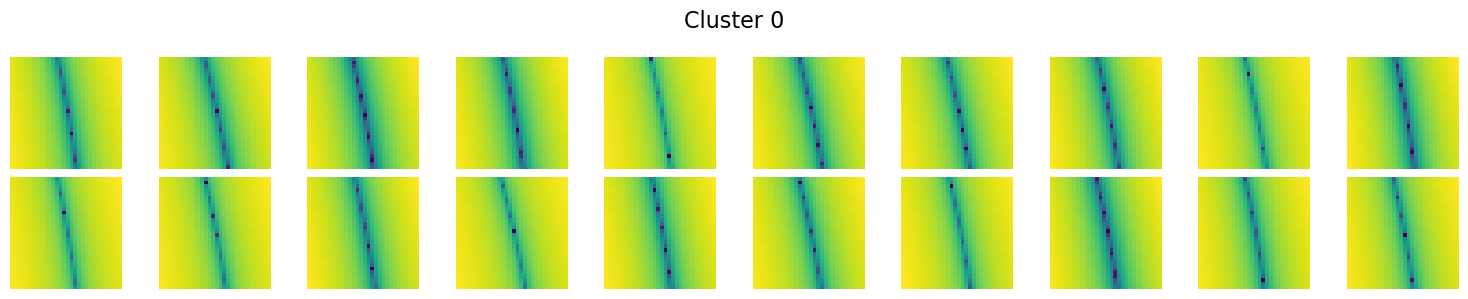

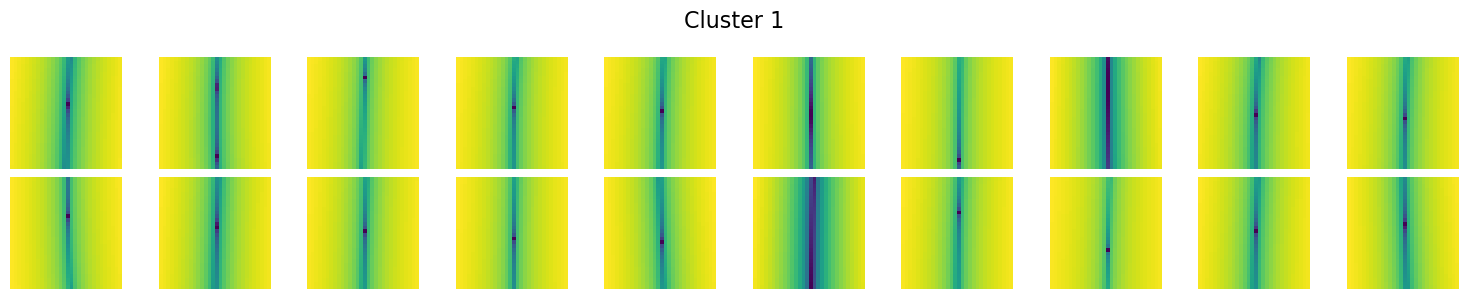

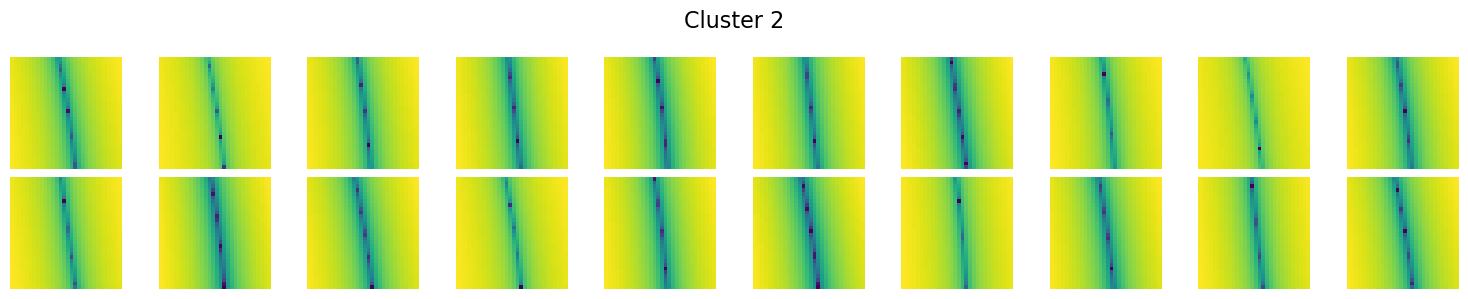

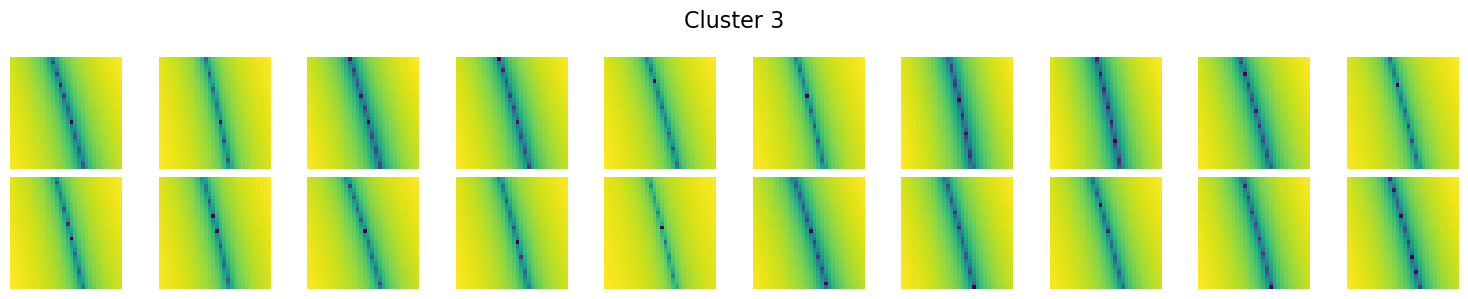

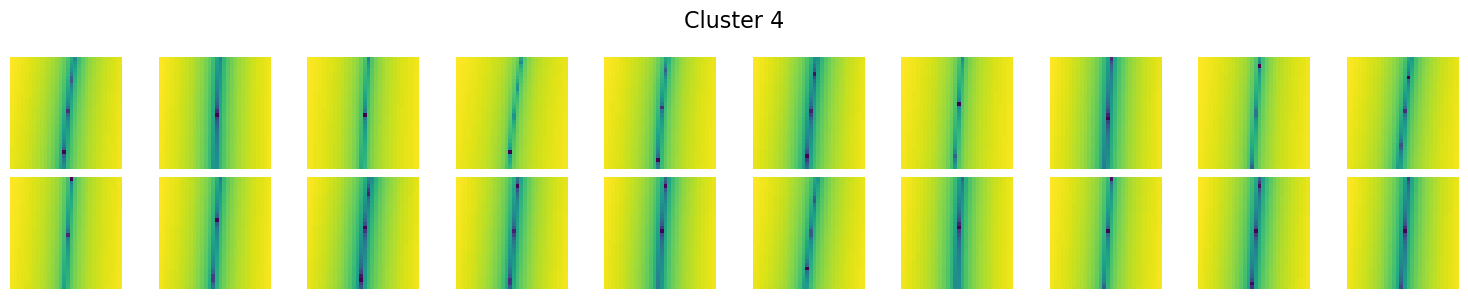

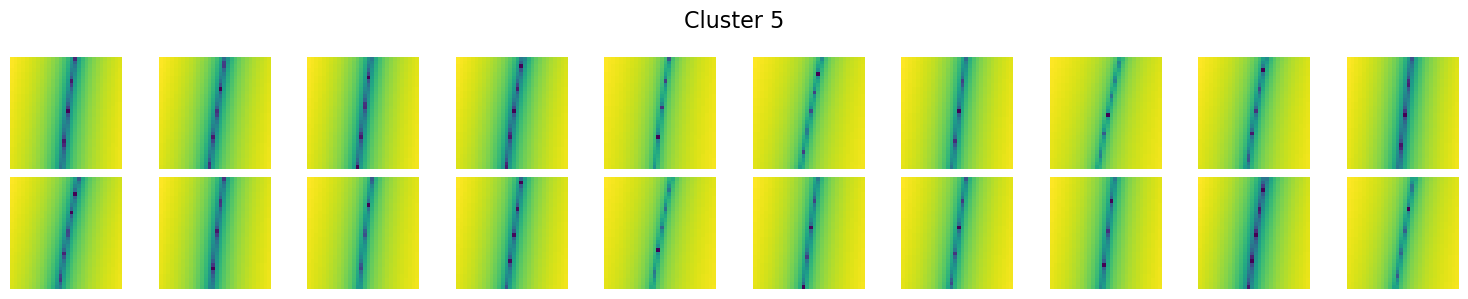

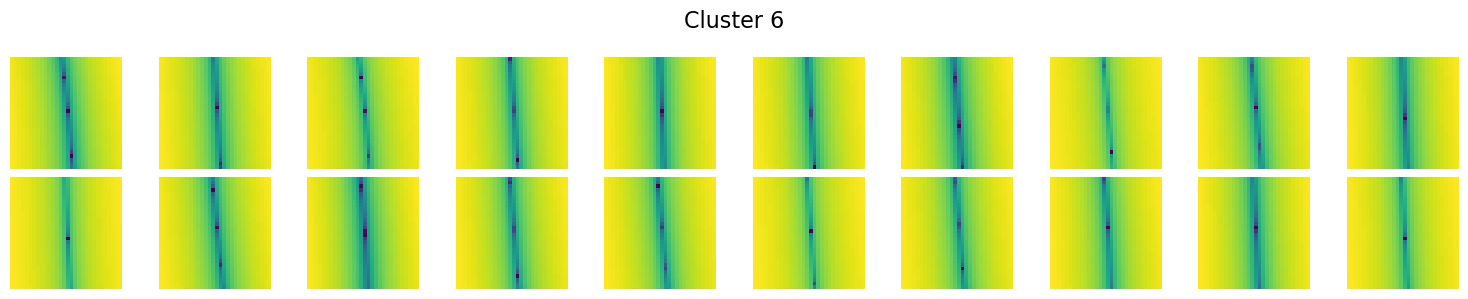

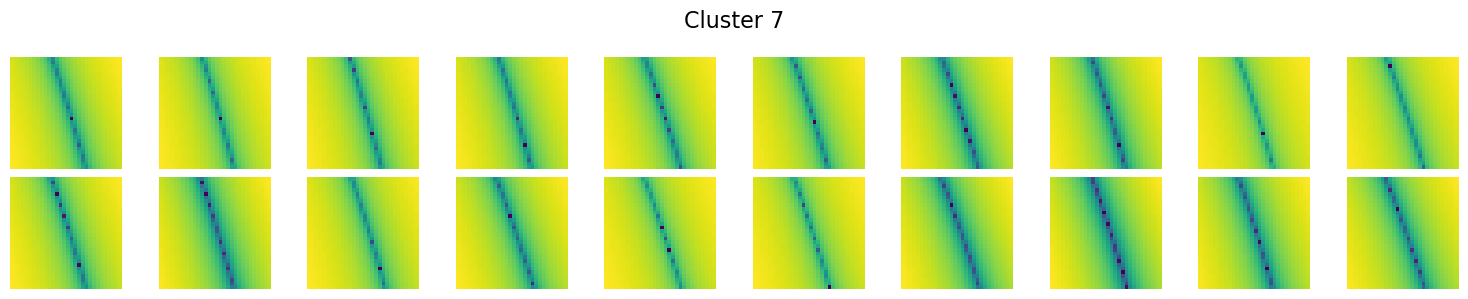

In [19]:
visualize_image_clusters(log_loss_landscape_array, k_means_labels,max_arrays_per_cluster=20)

### Function to compute tilt angle

In [20]:
from src.tilt_angle import compute_best_tilt

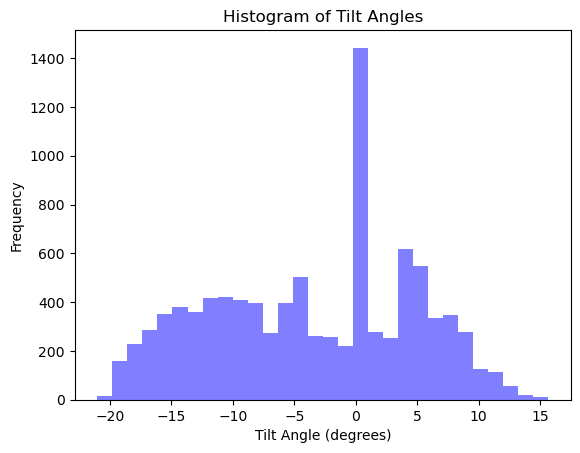

In [21]:
log_loss_landscape_array = loss_function_dict['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse']['fixed_Aug5_all_labeled_ON_EIGVEC_iter1_alignn1_lowest250_error_mse_log_loss_landscape_array'].copy()

angles = []
for i in range(len(log_loss_landscape_array.to_list())):
    angle, _ = compute_best_tilt(log_loss_landscape_array.to_list()[i], degrees=True,angle_mode='signed90', fit_mode='row')
    angles.append(angle)

#plot histogram of angles
plt.hist(angles, bins=30, alpha=0.5, color='blue')
plt.title('Histogram of Tilt Angles')
plt.xlabel('Tilt Angle (degrees)')
plt.ylabel('Frequency')
plt.show()

### Tilt angle result

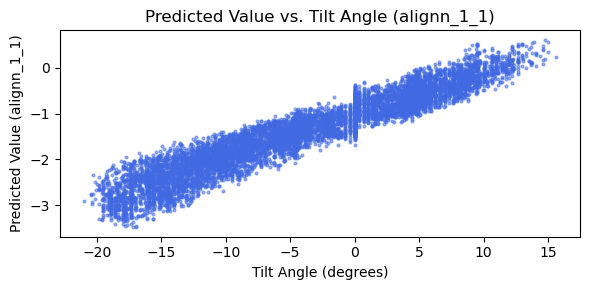

In [22]:
# Plot predicted values as a function of tilt angle
pred_vals = combined_dict['feat_sample_df']['pred_val_alignn_1_1']

# Add a vertical line at x=0 and a horizontal line at y=-1 to the previous plot
plt.figure(figsize=(6,3))
plt.scatter(angles, pred_vals, alpha=0.5, color='royalblue', edgecolor= None, s=4)
plt.xlabel('Tilt Angle (degrees)')
plt.ylabel('Predicted Value (alignn_1_1)')
plt.title('Predicted Value vs. Tilt Angle (alignn_1_1)')

plt.tight_layout()
plt.show()


### More plots

In [23]:
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Create boolean masks and get indices
iter1_train_indices = [i for i, jid in enumerate(all_data_jids) if jid in iter1_train_jids]
holdout_indices = [i for i, jid in enumerate(all_data_jids) if jid not in iter1_train_jids]
lowest_250_z_scores_jids = lowest_250_z_scores_jids
lowest_250_z_scores_indices = [i for i, jid in enumerate(all_data_jids) if jid in lowest_250_z_scores_jids]

# Get the data for all samples
dhf = combined_dict['feat_sample_df']['dHf']
z_score_err = combined_dict['feat_sample_df']['z_score_err_alignn_1_1']
abs_err = combined_dict['feat_sample_df']['abs_err_alignn_1_1']
err = combined_dict['feat_sample_df']['err_alignn_1_1']
pred_vals = combined_dict['feat_sample_df']['pred_val_alignn_1_1']

# Split data into iter1 train and holdout
dhf_train = dhf.iloc[iter1_train_indices]
z_score_train = z_score_err.iloc[iter1_train_indices]
pred_train = pred_vals.iloc[iter1_train_indices]
abs_err_train = abs_err.iloc[iter1_train_indices]
err_train = err.iloc[iter1_train_indices]
angles_train = np.array([angles[i] for i in iter1_train_indices])

dhf_holdout = dhf.iloc[holdout_indices]
z_score_holdout = z_score_err.iloc[holdout_indices]
pred_holdout = pred_vals.iloc[holdout_indices]
abs_err_holdout = abs_err.iloc[holdout_indices]
err_holdout = err.iloc[holdout_indices]
angles_holdout = np.array([angles[i] for i in holdout_indices])

dHf_lowest_250_z_scores = dhf.iloc[lowest_250_z_scores_indices]
z_score_lowest_250_z_scores = z_score_err.iloc[lowest_250_z_scores_indices]
pred_lowest_250_z_scores = pred_vals.iloc[lowest_250_z_scores_indices]
abs_err_lowest_250_z_scores = abs_err.iloc[lowest_250_z_scores_indices]
err_lowest_250_z_scores = err.iloc[lowest_250_z_scores_indices]
angles_lowest_250_z_scores = np.array([angles[i] for i in lowest_250_z_scores_indices])

# Remove NaN values for mutual information calculations
# Iter1 Train data
mask_train = ~(pd.isna(dhf_train) | pd.isna(z_score_train) | pd.isna(pred_train) | np.isnan(angles_train))
dhf_train_clean = dhf_train[mask_train].values
dhf_train_clean = np.array(dhf_train_clean, dtype=float)
z_score_train_clean = z_score_train[mask_train].values
abs_err_train_clean = abs_err_train[mask_train].values
err_train_clean = err_train[mask_train].values
pred_train_clean = pred_train[mask_train].values
angles_train_clean = angles_train[mask_train.values]

# Holdout data
mask_holdout = ~(pd.isna(dhf_holdout) | pd.isna(z_score_holdout) | pd.isna(pred_holdout) | np.isnan(angles_holdout))
dhf_holdout_clean = dhf_holdout[mask_holdout].values
dhf_holdout_clean = np.array(dhf_holdout_clean, dtype=float)
z_score_holdout_clean = z_score_holdout[mask_holdout].values
abs_err_holdout_clean = abs_err_holdout[mask_holdout].values
err_holdout_clean = err_holdout[mask_holdout].values
pred_holdout_clean = pred_holdout[mask_holdout].values
angles_holdout_clean = angles_holdout[mask_holdout.values]

# Lowest 250 z-score data
mask_lowest_250_z_scores = ~(pd.isna(dHf_lowest_250_z_scores) | pd.isna(z_score_lowest_250_z_scores) | pd.isna(pred_lowest_250_z_scores) | np.isnan(angles_lowest_250_z_scores))
dHf_lowest_250_z_scores_clean = dHf_lowest_250_z_scores[mask_lowest_250_z_scores].values
dHf_lowest_250_z_scores_clean = np.array(dHf_lowest_250_z_scores_clean, dtype=float)
z_score_lowest_250_z_scores_clean = z_score_lowest_250_z_scores[mask_lowest_250_z_scores].values
abs_err_lowest_250_z_scores_clean = abs_err_lowest_250_z_scores[mask_lowest_250_z_scores].values
err_lowest_250_z_scores_clean = err_lowest_250_z_scores[mask_lowest_250_z_scores].values
pred_lowest_250_z_scores_clean = pred_lowest_250_z_scores[mask_lowest_250_z_scores].values
angles_lowest_250_z_scores_clean = angles_lowest_250_z_scores[mask_lowest_250_z_scores.values]

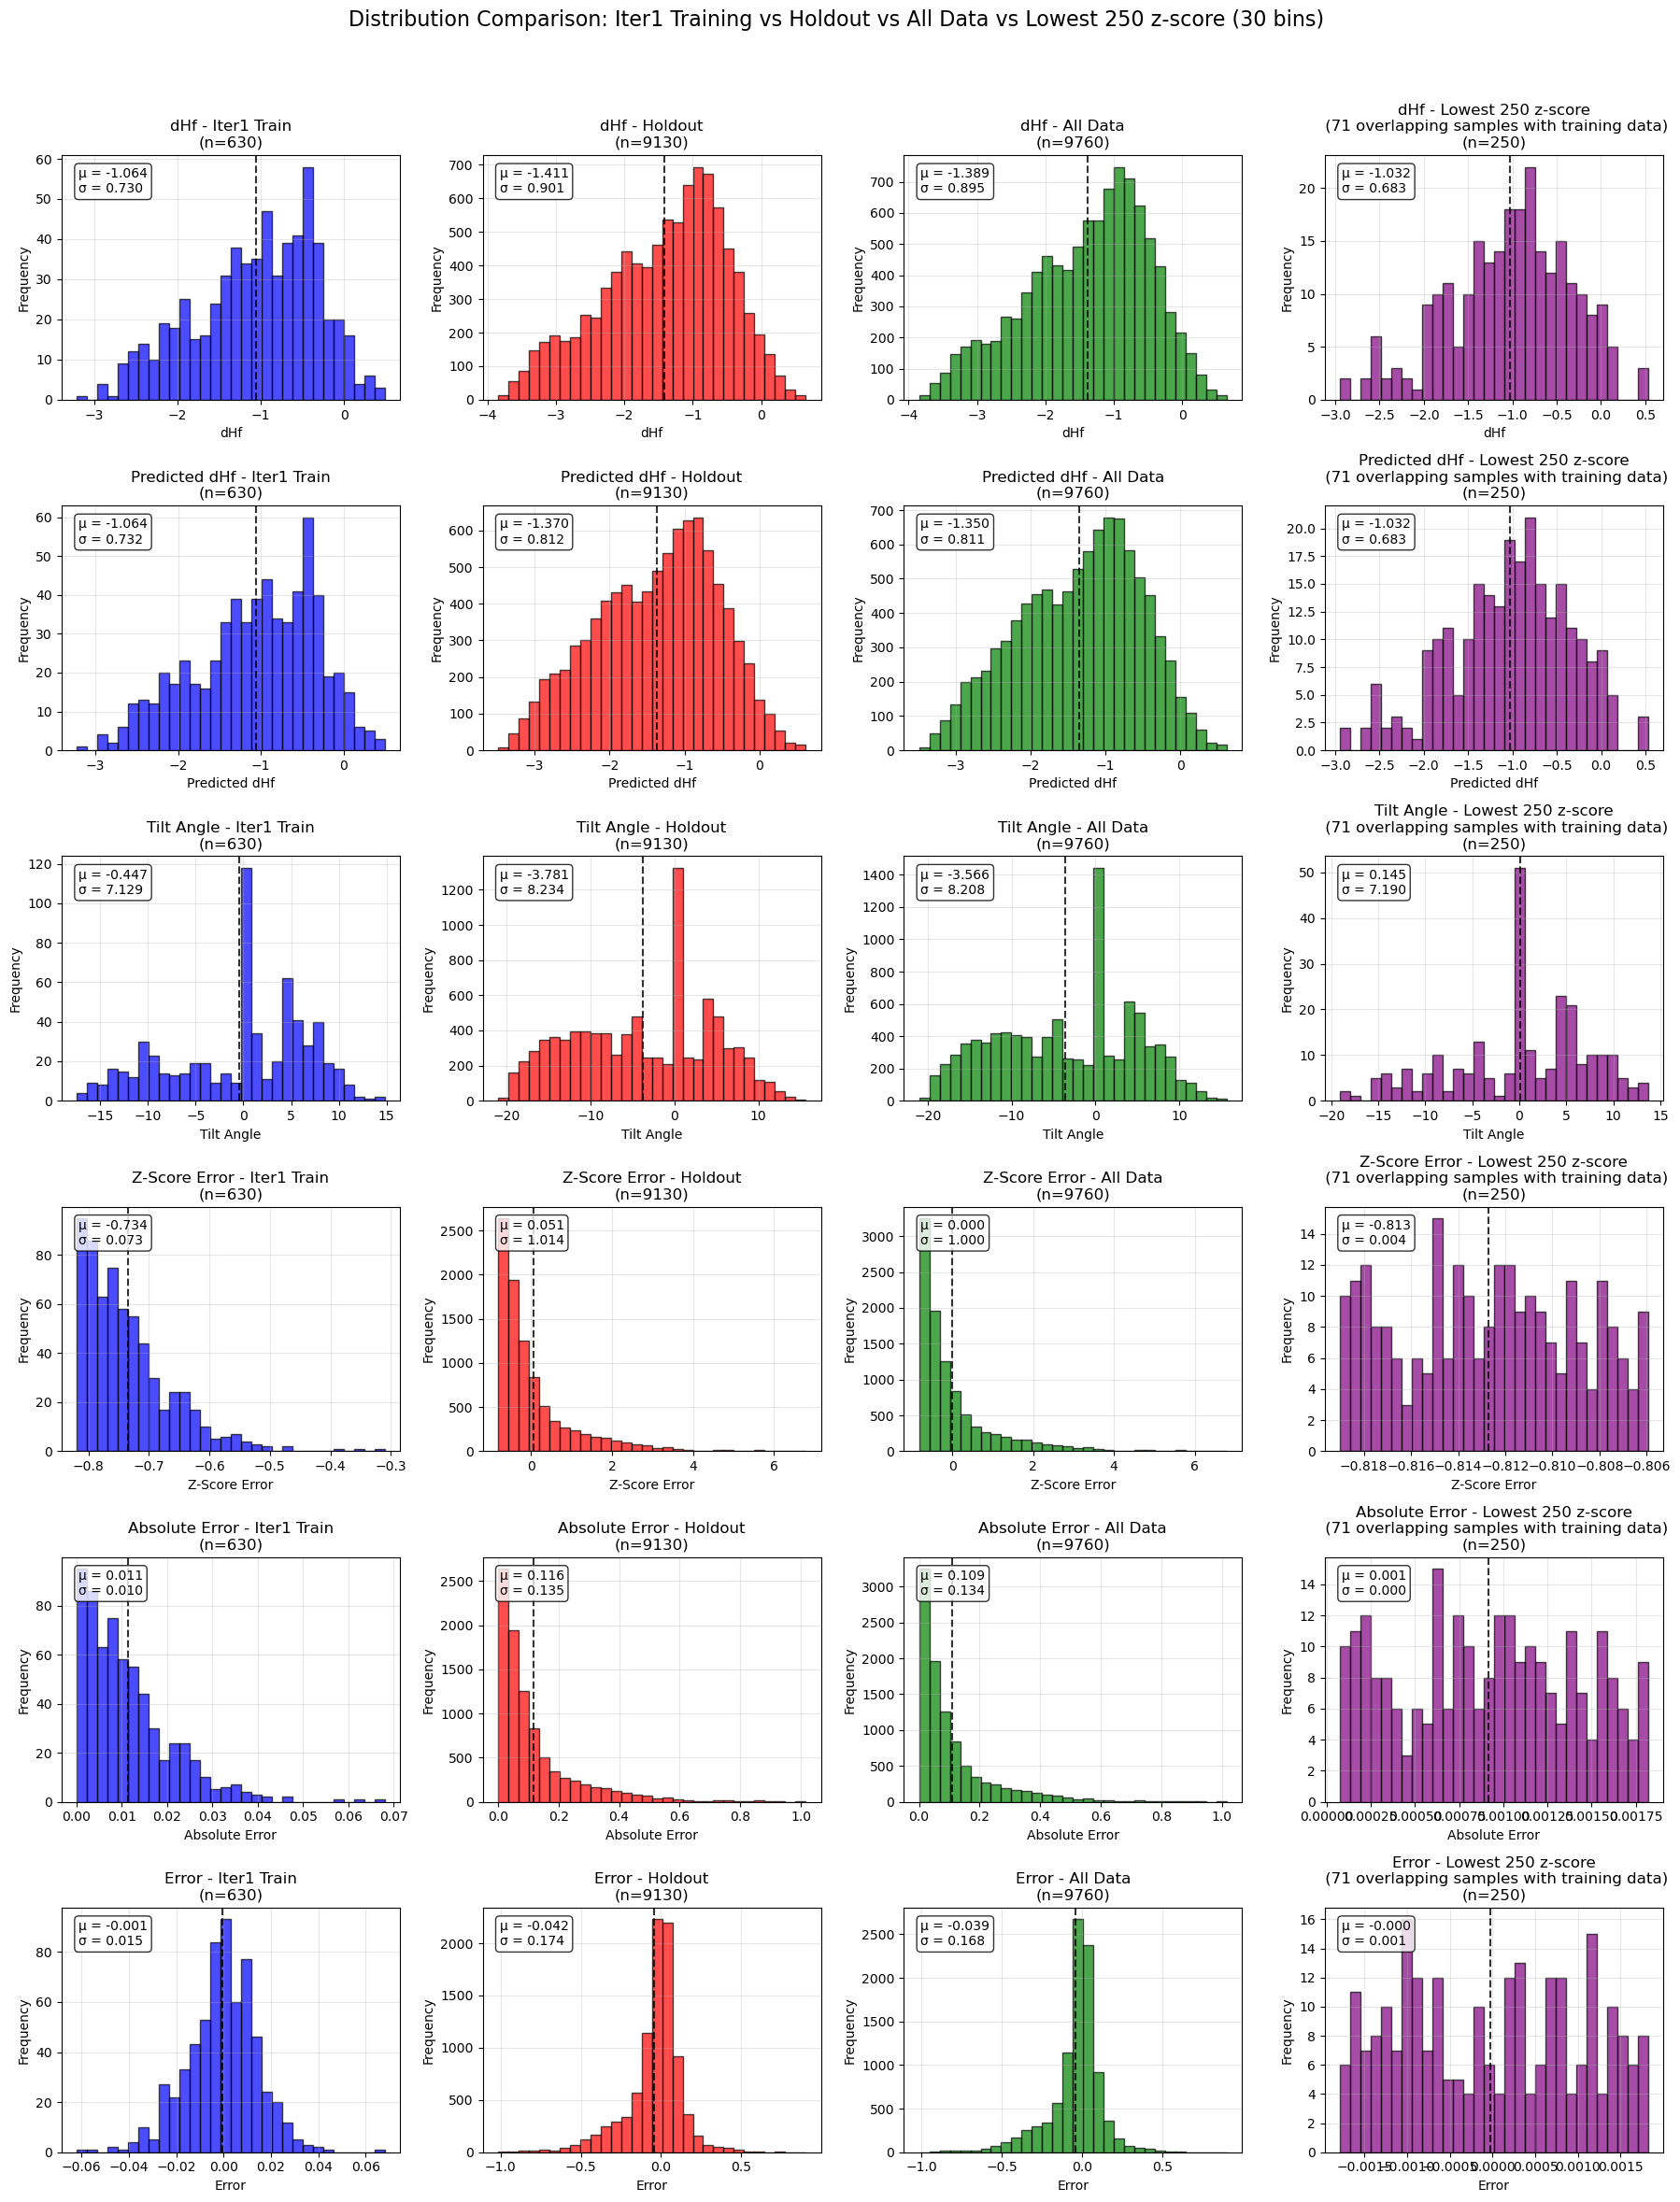

In [24]:
# Generate histograms for different data splits
fig, axes = plt.subplots(6, 4, figsize=(18, 24))

# Data labels and colors
data_labels = ['Iter1 Train', 'Holdout', 'All Data', 'Lowest 250 z-score\n (71 overlapping samples with training data)']
colors = ['blue', 'red', 'green', 'purple']
alpha = 0.7

# Variable names and data
variables = [
    ('dHf', [dhf_train_clean, dhf_holdout_clean, dhf.dropna().values, dHf_lowest_250_z_scores_clean]),
    ('Predicted dHf', [pred_train_clean, pred_holdout_clean, pred_vals.dropna().values, pred_lowest_250_z_scores_clean]),
    ('Tilt Angle', [angles_train_clean, angles_holdout_clean, angles, angles_lowest_250_z_scores_clean]),
    ('Z-Score Error', [z_score_train_clean, z_score_holdout_clean, z_score_err.dropna().values, z_score_lowest_250_z_scores_clean]),
    ('Absolute Error', [abs_err_train_clean, abs_err_holdout_clean, abs_err.dropna().values, abs_err_lowest_250_z_scores_clean]),
    ('Error', [err_train_clean, err_holdout_clean, err.dropna().values, err_lowest_250_z_scores_clean])
]

# Create histograms
for row, (var_name, data_sets) in enumerate(variables):
    for col, (data, label, color) in enumerate(zip(data_sets, data_labels, colors)):
        if len(data) > 0:
            axes[row, col].hist(data, bins=30, alpha=alpha, color=color, edgecolor='black')
            axes[row, col].set_title(f'{var_name} - {label}\n(n={len(data)})')
            axes[row, col].set_xlabel(var_name)
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add statistics text
            mean_val = np.mean(data)
            std_val = np.std(data)
            axes[row, col].axvline(mean_val, color='black', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.3f}')
            axes[row, col].text(0.05, 0.95, f'μ = {mean_val:.3f}\nσ = {std_val:.3f}', 
                               transform=axes[row, col].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[row, col].text(0.5, 0.5, 'No data available', ha='center', va='center', 
                               transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'{var_name} - {label}')

plt.suptitle('Distribution Comparison: Iter1 Training vs Holdout vs All Data vs Lowest 250 z-score (30 bins)', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [25]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

# Calculate Mutual Information for different data splits using histogram bins
print("\nMutual Information Analysis (Using Histogram Bins):")
print("=" * 60)

# Prepare all data (combined train and holdout)
dhf_all = np.concatenate([dhf_train_clean, dhf_holdout_clean])
z_score_all = np.concatenate([z_score_train_clean, z_score_holdout_clean])
pred_all = np.concatenate([pred_train_clean, pred_holdout_clean])
angles_all = np.concatenate([angles_train_clean, angles_holdout_clean])
abs_err_all = np.concatenate([abs_err_train_clean, abs_err_holdout_clean])
err_all = np.concatenate([err_train_clean, err_holdout_clean])

datasets = {
    'Iter1 Train': (dhf_train_clean, z_score_train_clean, pred_train_clean, angles_train_clean, abs_err_train_clean, err_train_clean),
    'Holdout': (dhf_holdout_clean, z_score_holdout_clean, pred_holdout_clean, angles_holdout_clean, abs_err_holdout_clean, err_holdout_clean),
    'All Data': (dhf_all, z_score_all, pred_all, angles_all, abs_err_all, err_all),
    'Lowest 250 z-score': (dHf_lowest_250_z_scores_clean, z_score_lowest_250_z_scores_clean, pred_lowest_250_z_scores_clean, angles_lowest_250_z_scores_clean, abs_err_lowest_250_z_scores_clean, err_lowest_250_z_scores_clean)
}

def discretize_to_bins(data, n_bins=30):
    """Convert continuous data to discrete bin labels"""
    if len(data) == 0:
        return np.array([])
    
    # Create histogram bins
    hist, bin_edges = np.histogram(data, bins=n_bins)
    
    # Assign each data point to a bin number
    bin_labels = np.digitize(data, bin_edges) - 1
    # Ensure all labels are within valid range [0, n_bins-1]
    bin_labels = np.clip(bin_labels, 0, n_bins-1)
    
    return bin_labels

# Calculate and display mutual information for each dataset
nmi_scores = {}

for dataset_name, (dhf_data, z_score_data, pred_data, angle_data, abs_err_data, err_data) in datasets.items():
    print(f"\n{dataset_name.upper()}:")
    print("-" * 40)
    
    if len(dhf_data) > 0:
        # Discretize continuous variables into histogram bins
        dhf_bins = discretize_to_bins(dhf_data, n_bins=30)
        z_score_bins = discretize_to_bins(z_score_data, n_bins=30)
        pred_bins = discretize_to_bins(pred_data, n_bins=30)
        angle_bins = discretize_to_bins(angle_data, n_bins=30)
        
        # Calculate normalized mutual information using sklearn's normalized_mutual_info_score
        from sklearn.metrics import normalized_mutual_info_score
        
        nmi_dhf_pred = normalized_mutual_info_score(dhf_bins, pred_bins)
        nmi_pred_zscore = normalized_mutual_info_score(pred_bins, z_score_bins)
        nmi_dhf_zscore = normalized_mutual_info_score(dhf_bins, z_score_bins)
        nmi_dhf_angle = normalized_mutual_info_score(dhf_bins, angle_bins)
        nmi_pred_angle = normalized_mutual_info_score(pred_bins, angle_bins)
        nmi_zscore_angle = normalized_mutual_info_score(z_score_bins, angle_bins)
        
        # Save NMI scores
        nmi_scores[dataset_name] = {
            'nmi_dhf_pred': nmi_dhf_pred,
            'nmi_pred_zscore': nmi_pred_zscore,
            'nmi_dhf_zscore': nmi_dhf_zscore,
            'nmi_dhf_angle': nmi_dhf_angle,
            'nmi_pred_angle': nmi_pred_angle,
            'nmi_zscore_angle': nmi_zscore_angle
        }
        
        print(f"Normalized MI between dHf_bins and z_score_bins: {nmi_dhf_zscore:.4f}")
        print(f"Normalized MI between dHf_bins and predicted_bins: {nmi_dhf_pred:.4f}")
        print(f"Normalized MI between z_score_bins and angle_bins: {nmi_zscore_angle:.4f}")
        print(f"Normalized MI between pred_bins and angle_bins: {nmi_pred_angle:.4f}")
        print(f"Normalized MI between dHf_bins and angle_bins: {nmi_dhf_angle:.4f}")
        print(f"Normalized MI between pred_bins and z_score_bins: {nmi_pred_zscore:.4f}")
        
        print(f"Sample size: {len(dhf_data)}")
        print(f"Number of bins used: 30")
    else:
        print("No valid data available")




Mutual Information Analysis (Using Histogram Bins):

ITER1 TRAIN:
----------------------------------------
Normalized MI between dHf_bins and z_score_bins: 0.1392
Normalized MI between dHf_bins and predicted_bins: 0.8872
Normalized MI between z_score_bins and angle_bins: 0.1371
Normalized MI between pred_bins and angle_bins: 0.4293
Normalized MI between dHf_bins and angle_bins: 0.4278
Normalized MI between pred_bins and z_score_bins: 0.1248
Sample size: 630
Number of bins used: 30

HOLDOUT:
----------------------------------------
Normalized MI between dHf_bins and z_score_bins: 0.0836
Normalized MI between dHf_bins and predicted_bins: 0.5724
Normalized MI between z_score_bins and angle_bins: 0.0692
Normalized MI between pred_bins and angle_bins: 0.3782
Normalized MI between dHf_bins and angle_bins: 0.3471
Normalized MI between pred_bins and z_score_bins: 0.0658
Sample size: 9130
Number of bins used: 30

ALL DATA:
----------------------------------------
Normalized MI between dHf_bins

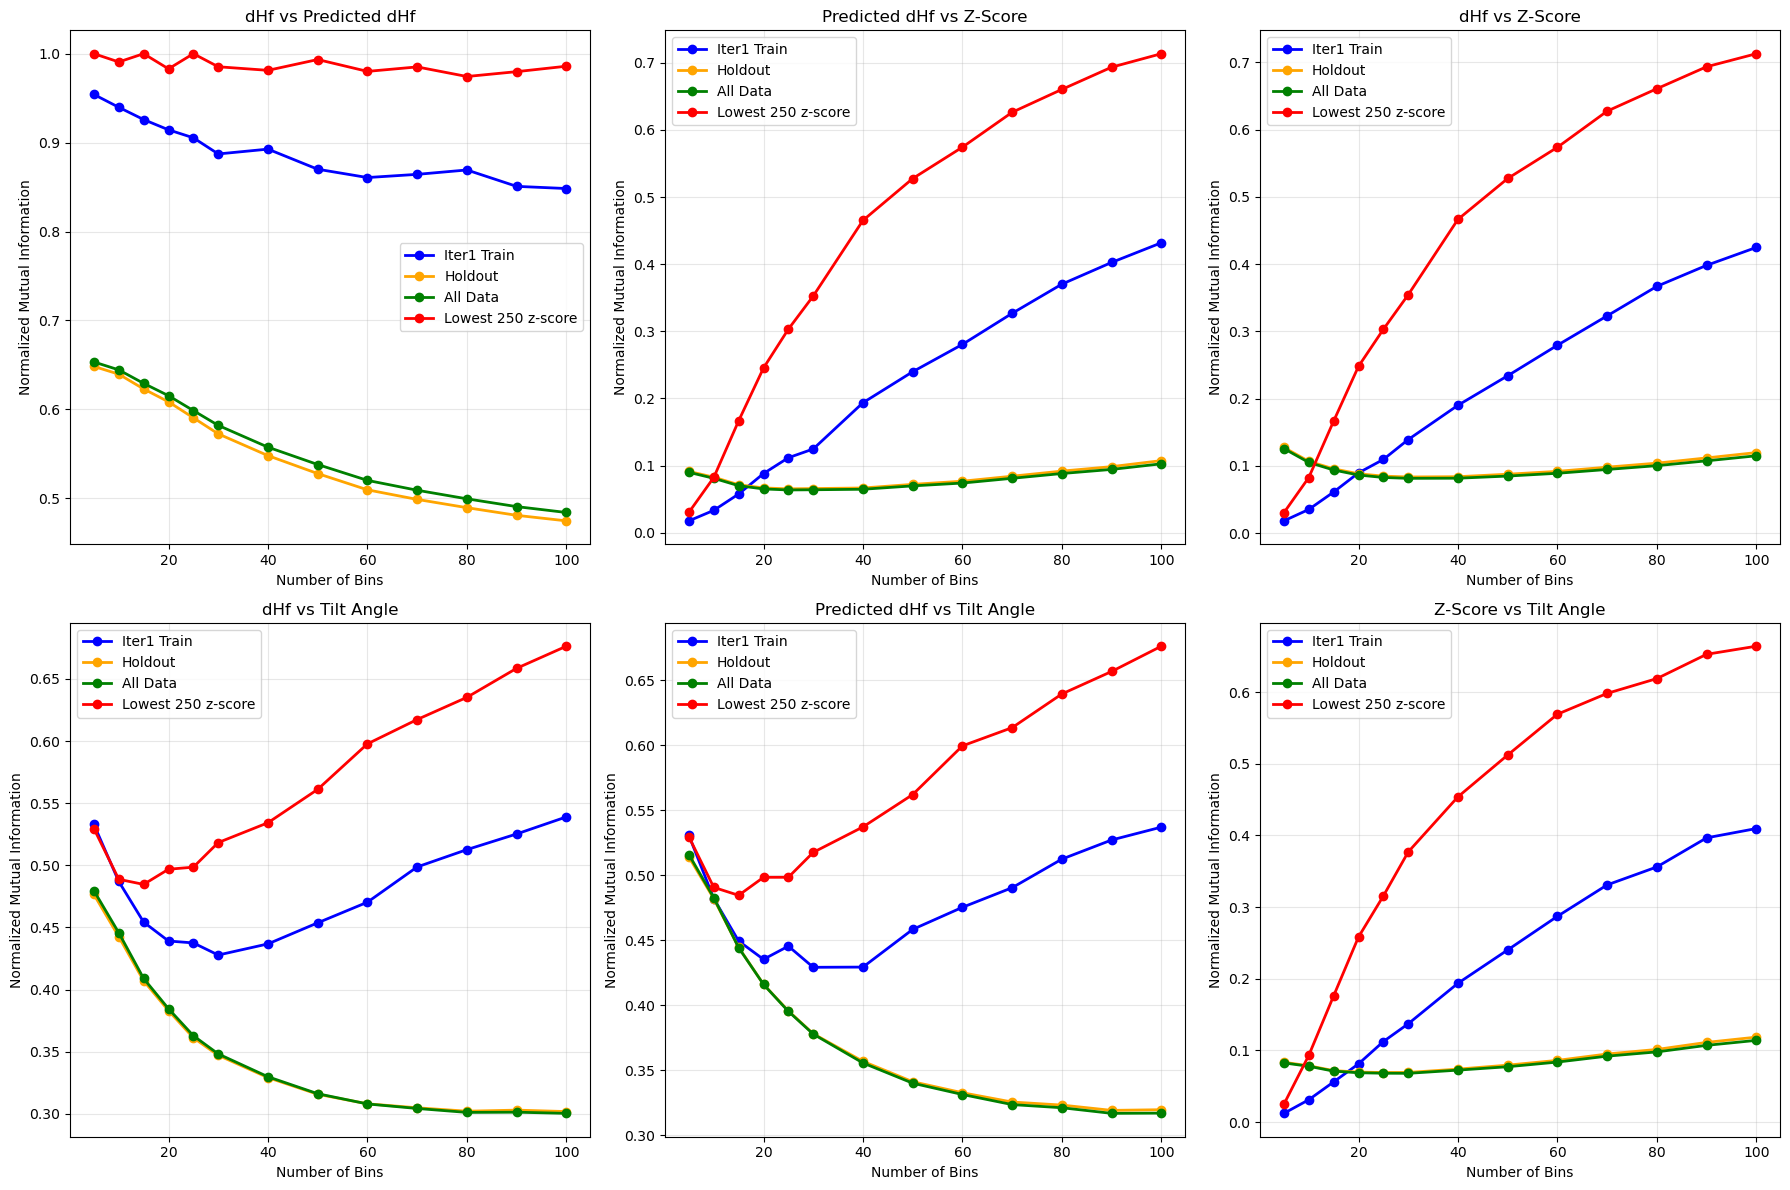

In [26]:
# Analyze how NMI scores change with different numbers of bins
bin_ranges = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
nmi_vs_bins = {}

for dataset_name, (dhf_data, z_score_data, pred_data, angle_data, abs_err_data, err_data) in datasets.items():
    if len(dhf_data) > 0:
        nmi_vs_bins[dataset_name] = {
            'bins': [],
            'nmi_dhf_pred': [],
            'nmi_pred_zscore': [],
            'nmi_dhf_zscore': [],
            'nmi_dhf_angle': [],
            'nmi_pred_angle': [],
            'nmi_zscore_angle': []
        }
        
        for n_bins in bin_ranges:
            # Discretize continuous variables into histogram bins
            dhf_bins = discretize_to_bins(dhf_data, n_bins=n_bins)
            z_score_bins = discretize_to_bins(z_score_data, n_bins=n_bins)
            pred_bins = discretize_to_bins(pred_data, n_bins=n_bins)
            angle_bins = discretize_to_bins(angle_data, n_bins=n_bins)
            
            # Calculate NMI scores
            nmi_dhf_pred = normalized_mutual_info_score(dhf_bins, pred_bins)
            nmi_pred_zscore = normalized_mutual_info_score(pred_bins, z_score_bins)
            nmi_dhf_zscore = normalized_mutual_info_score(dhf_bins, z_score_bins)
            nmi_dhf_angle = normalized_mutual_info_score(dhf_bins, angle_bins)
            nmi_pred_angle = normalized_mutual_info_score(pred_bins, angle_bins)
            nmi_zscore_angle = normalized_mutual_info_score(z_score_bins, angle_bins)
            
            # Store results
            nmi_vs_bins[dataset_name]['bins'].append(n_bins)
            nmi_vs_bins[dataset_name]['nmi_dhf_pred'].append(nmi_dhf_pred)
            nmi_vs_bins[dataset_name]['nmi_pred_zscore'].append(nmi_pred_zscore)
            nmi_vs_bins[dataset_name]['nmi_dhf_zscore'].append(nmi_dhf_zscore)
            nmi_vs_bins[dataset_name]['nmi_dhf_angle'].append(nmi_dhf_angle)
            nmi_vs_bins[dataset_name]['nmi_pred_angle'].append(nmi_pred_angle)
            nmi_vs_bins[dataset_name]['nmi_zscore_angle'].append(nmi_zscore_angle)

# Plot NMI scores vs number of bins
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

nmi_pairs = [
    ('nmi_dhf_pred', 'dHf vs Predicted dHf'),
    ('nmi_pred_zscore', 'Predicted dHf vs Z-Score'),
    ('nmi_dhf_zscore', 'dHf vs Z-Score'),
    ('nmi_dhf_angle', 'dHf vs Tilt Angle'),
    ('nmi_pred_angle', 'Predicted dHf vs Tilt Angle'),
    ('nmi_zscore_angle', 'Z-Score vs Tilt Angle')
]

colors = ['blue', 'orange', 'green', 'red']
dataset_names = ['Iter1 Train', 'Holdout', 'All Data', 'Lowest 250 z-score']

for i, (nmi_key, title) in enumerate(nmi_pairs):
    ax = axes[i]
    
    for j, (dataset_name, color) in enumerate(zip(dataset_names, colors)):
        if dataset_name in nmi_vs_bins and len(nmi_vs_bins[dataset_name]['bins']) > 0:
            ax.plot(nmi_vs_bins[dataset_name]['bins'], 
                   nmi_vs_bins[dataset_name][nmi_key], 
                   marker='o', linewidth=2, markersize=6,
                   color=color, label=dataset_name)
    
    ax.set_xlabel('Number of Bins')
    ax.set_ylabel('Normalized Mutual Information')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


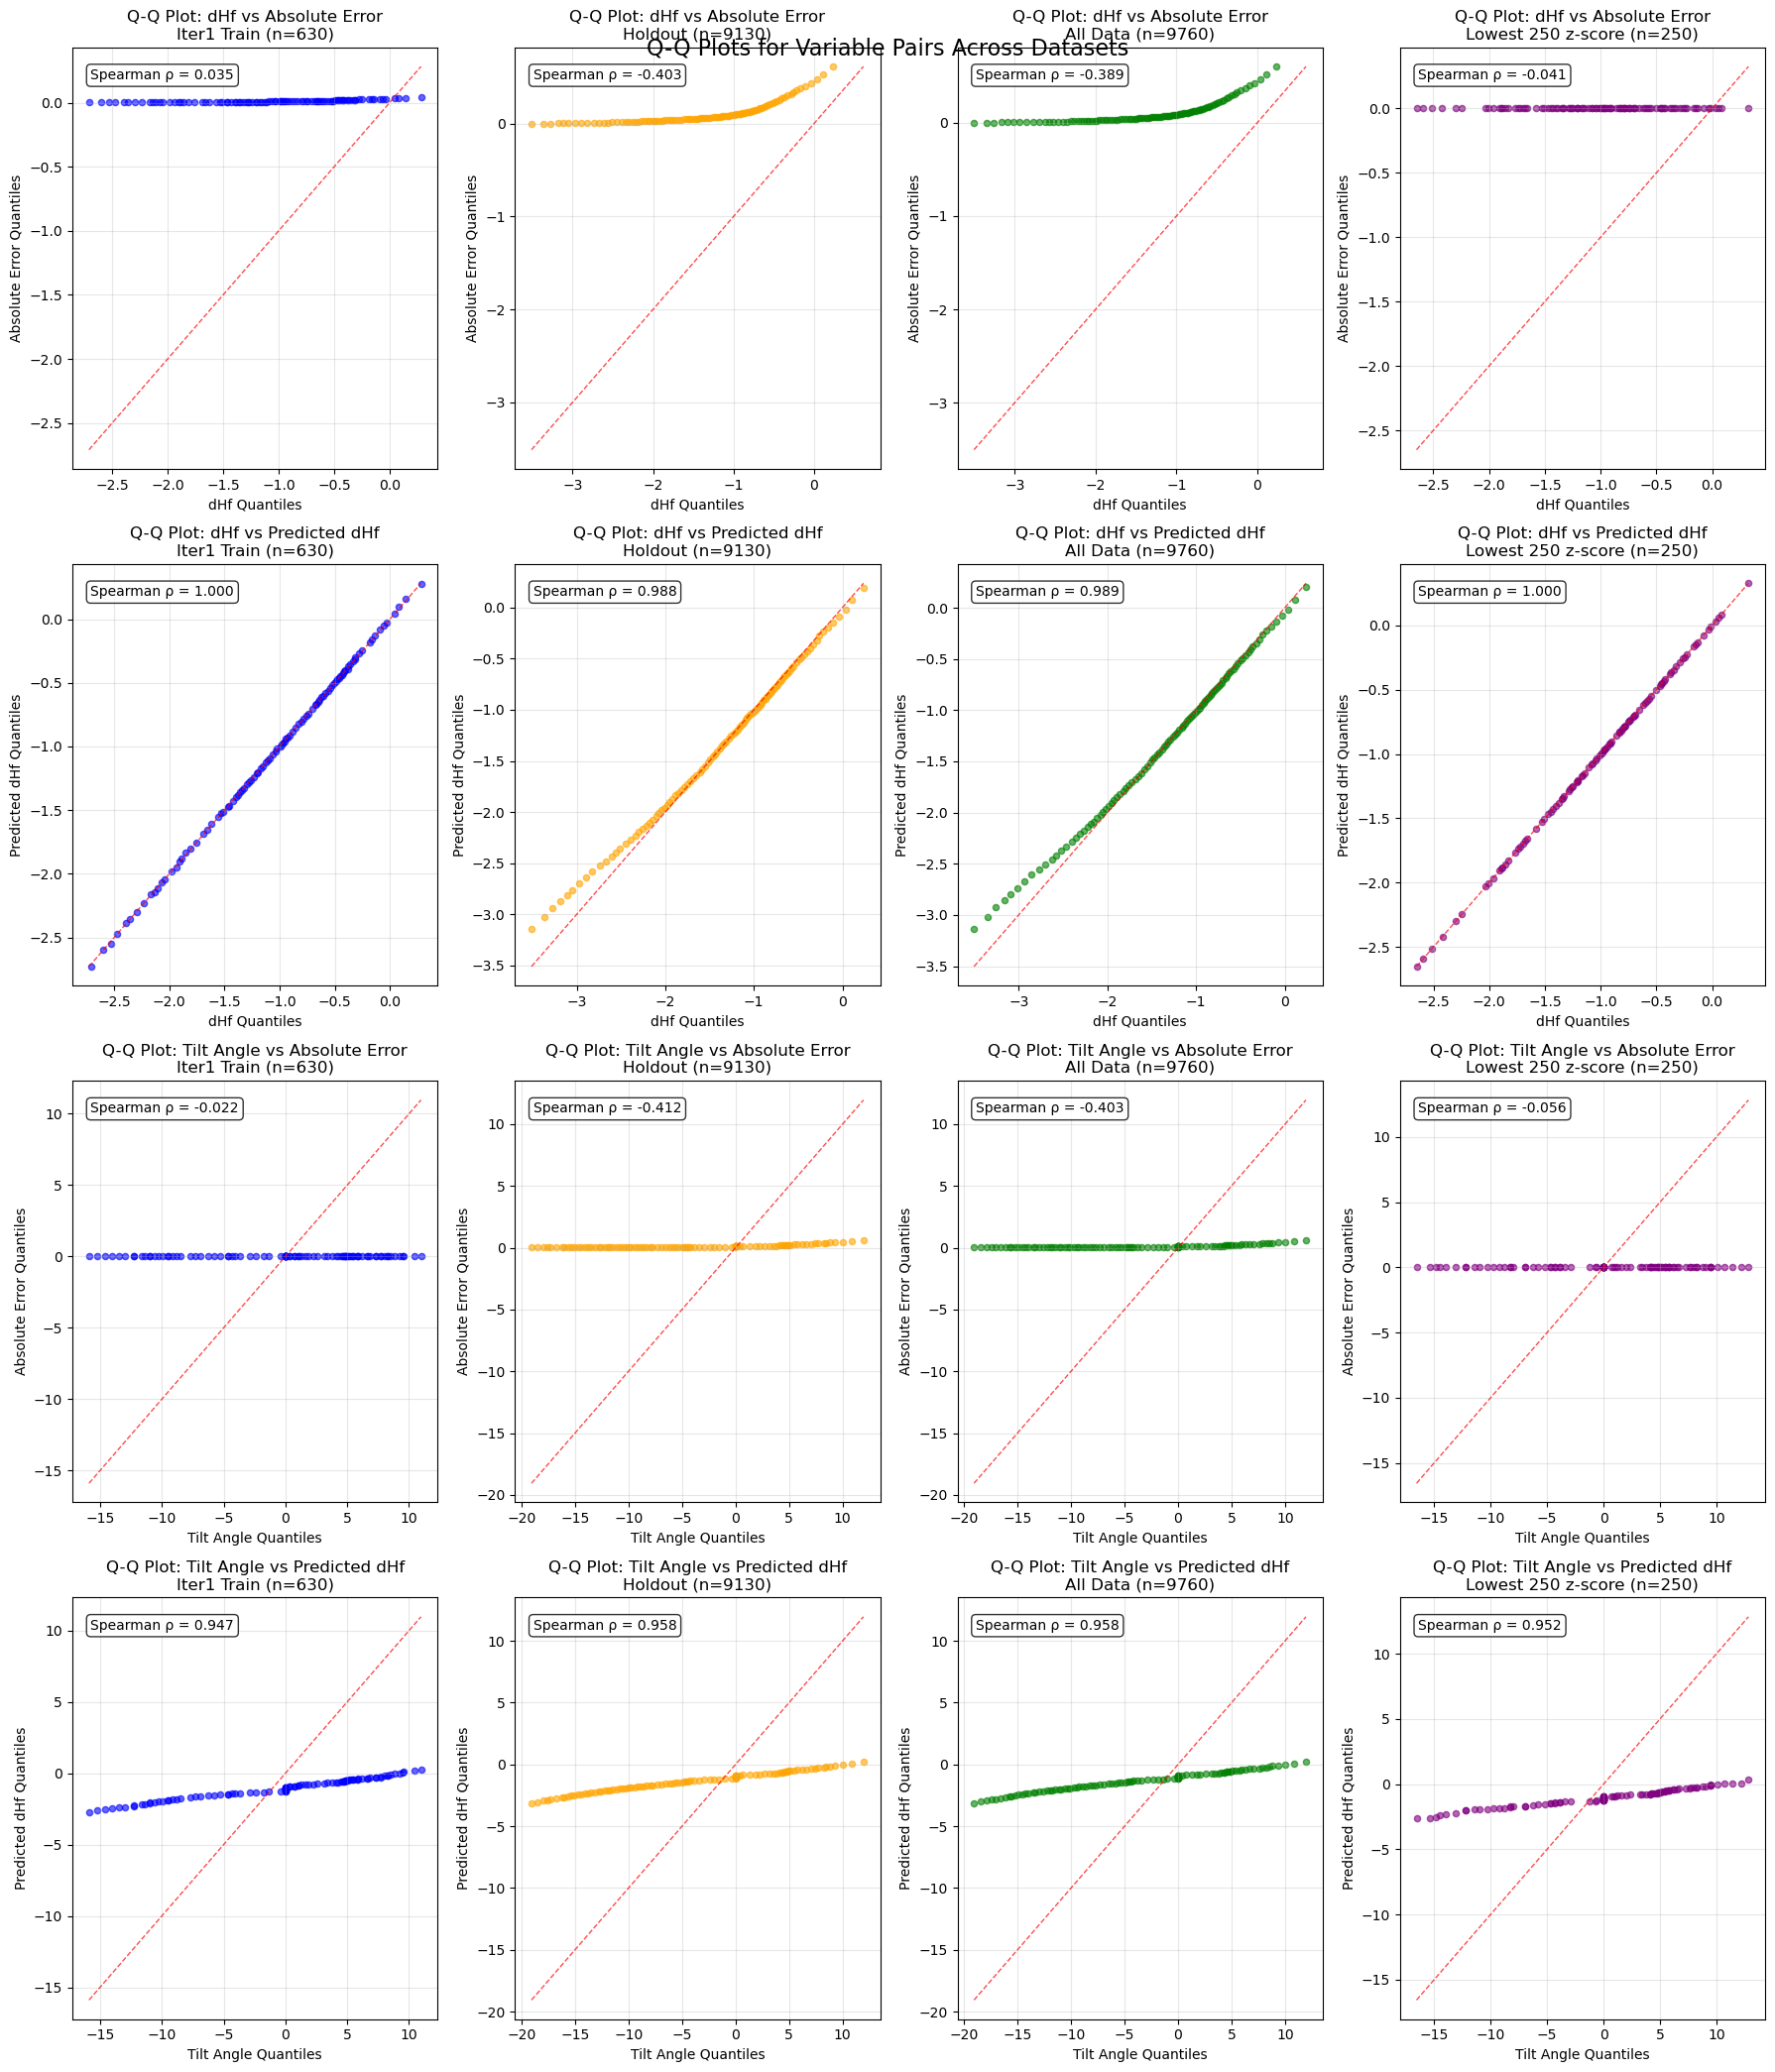

In [27]:

# %% cell 39 code - Q-Q Plots

from scipy import stats

# Create Q-Q plots for each variable pair
fig, axes = plt.subplots(4, 4, figsize=(18, 21))

qq_pairs = [
    ('dHf', 'Absolute Error'),
    ('dHf', 'Predicted dHf'),
    ('Tilt Angle', 'Absolute Error'),
    ('Tilt Angle', 'Predicted dHf')
]

colors = ['blue', 'orange', 'green', 'purple']

i=0

for row, (x_label, y_label) in enumerate(qq_pairs):
    for col, (dataset_name, color) in enumerate(zip(['Iter1 Train', 'Holdout', 'All Data', 'Lowest 250 z-score'], colors)):
        dataset_tuple = datasets[dataset_name]
        
        if row == 0:  # dHf vs Absolute Error
            x_data, y_data = dataset_tuple[0], dataset_tuple[4]
        elif row == 1:  # dHf vs Predicted dHf
            x_data, y_data = dataset_tuple[0], dataset_tuple[2]
        elif row == 2:  # Tilt Angle vs Absolute Error
            x_data, y_data = dataset_tuple[3], dataset_tuple[4]
        else:  # Tilt Angle vs Predicted dHf
            x_data, y_data = dataset_tuple[3], dataset_tuple[2]
        
        if len(x_data) > 0 and len(y_data) > 0:

            # Calculate quantiles for both variables
            n_quantiles = min(100, len(x_data))  # Use up to 100 quantiles or sample size
            quantiles = np.linspace(0.01, 0.99, n_quantiles)
            
            x_quantiles = np.percentile(x_data, quantiles * 100)
            y_quantiles = np.percentile(y_data, quantiles * 100)
    
            
            # Create Q-Q plot
            axes[row, col].scatter(x_quantiles, y_quantiles, alpha=0.6, color=color, s=20)
            
            # Add diagonal reference line
            min_val = min(np.min(x_quantiles), np.min(y_quantiles))
            max_val = max(np.max(x_quantiles), np.max(y_quantiles))
            axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=1)
            
            axes[row, col].set_xlabel(f'{x_label} Quantiles')
            axes[row, col].set_ylabel(f'{y_label} Quantiles')
            axes[row, col].set_title(f'Q-Q Plot: {x_label} vs {y_label}\n{dataset_name} (n={len(x_data)})')
            axes[row, col].grid(True, alpha=0.3)
            
            # Calculate and display Spearman correlation (rank-based)
            if len(x_data) > 1:
                spearman_corr, _ = stats.spearmanr(x_data, y_data)
                axes[row, col].text(0.05, 0.95, f'Spearman ρ = {spearman_corr:.3f}', 
                                   transform=axes[row, col].transAxes, verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[row, col].text(0.5, 0.5, 'No data available', 
                               transform=axes[row, col].transAxes, ha='center', va='center')
            axes[row, col].set_title(f'Q-Q Plot: {x_label} vs {y_label}\n{dataset_name}')

plt.tight_layout()
plt.suptitle('Q-Q Plots for Variable Pairs Across Datasets', fontsize=16, y=0.98)
plt.show()


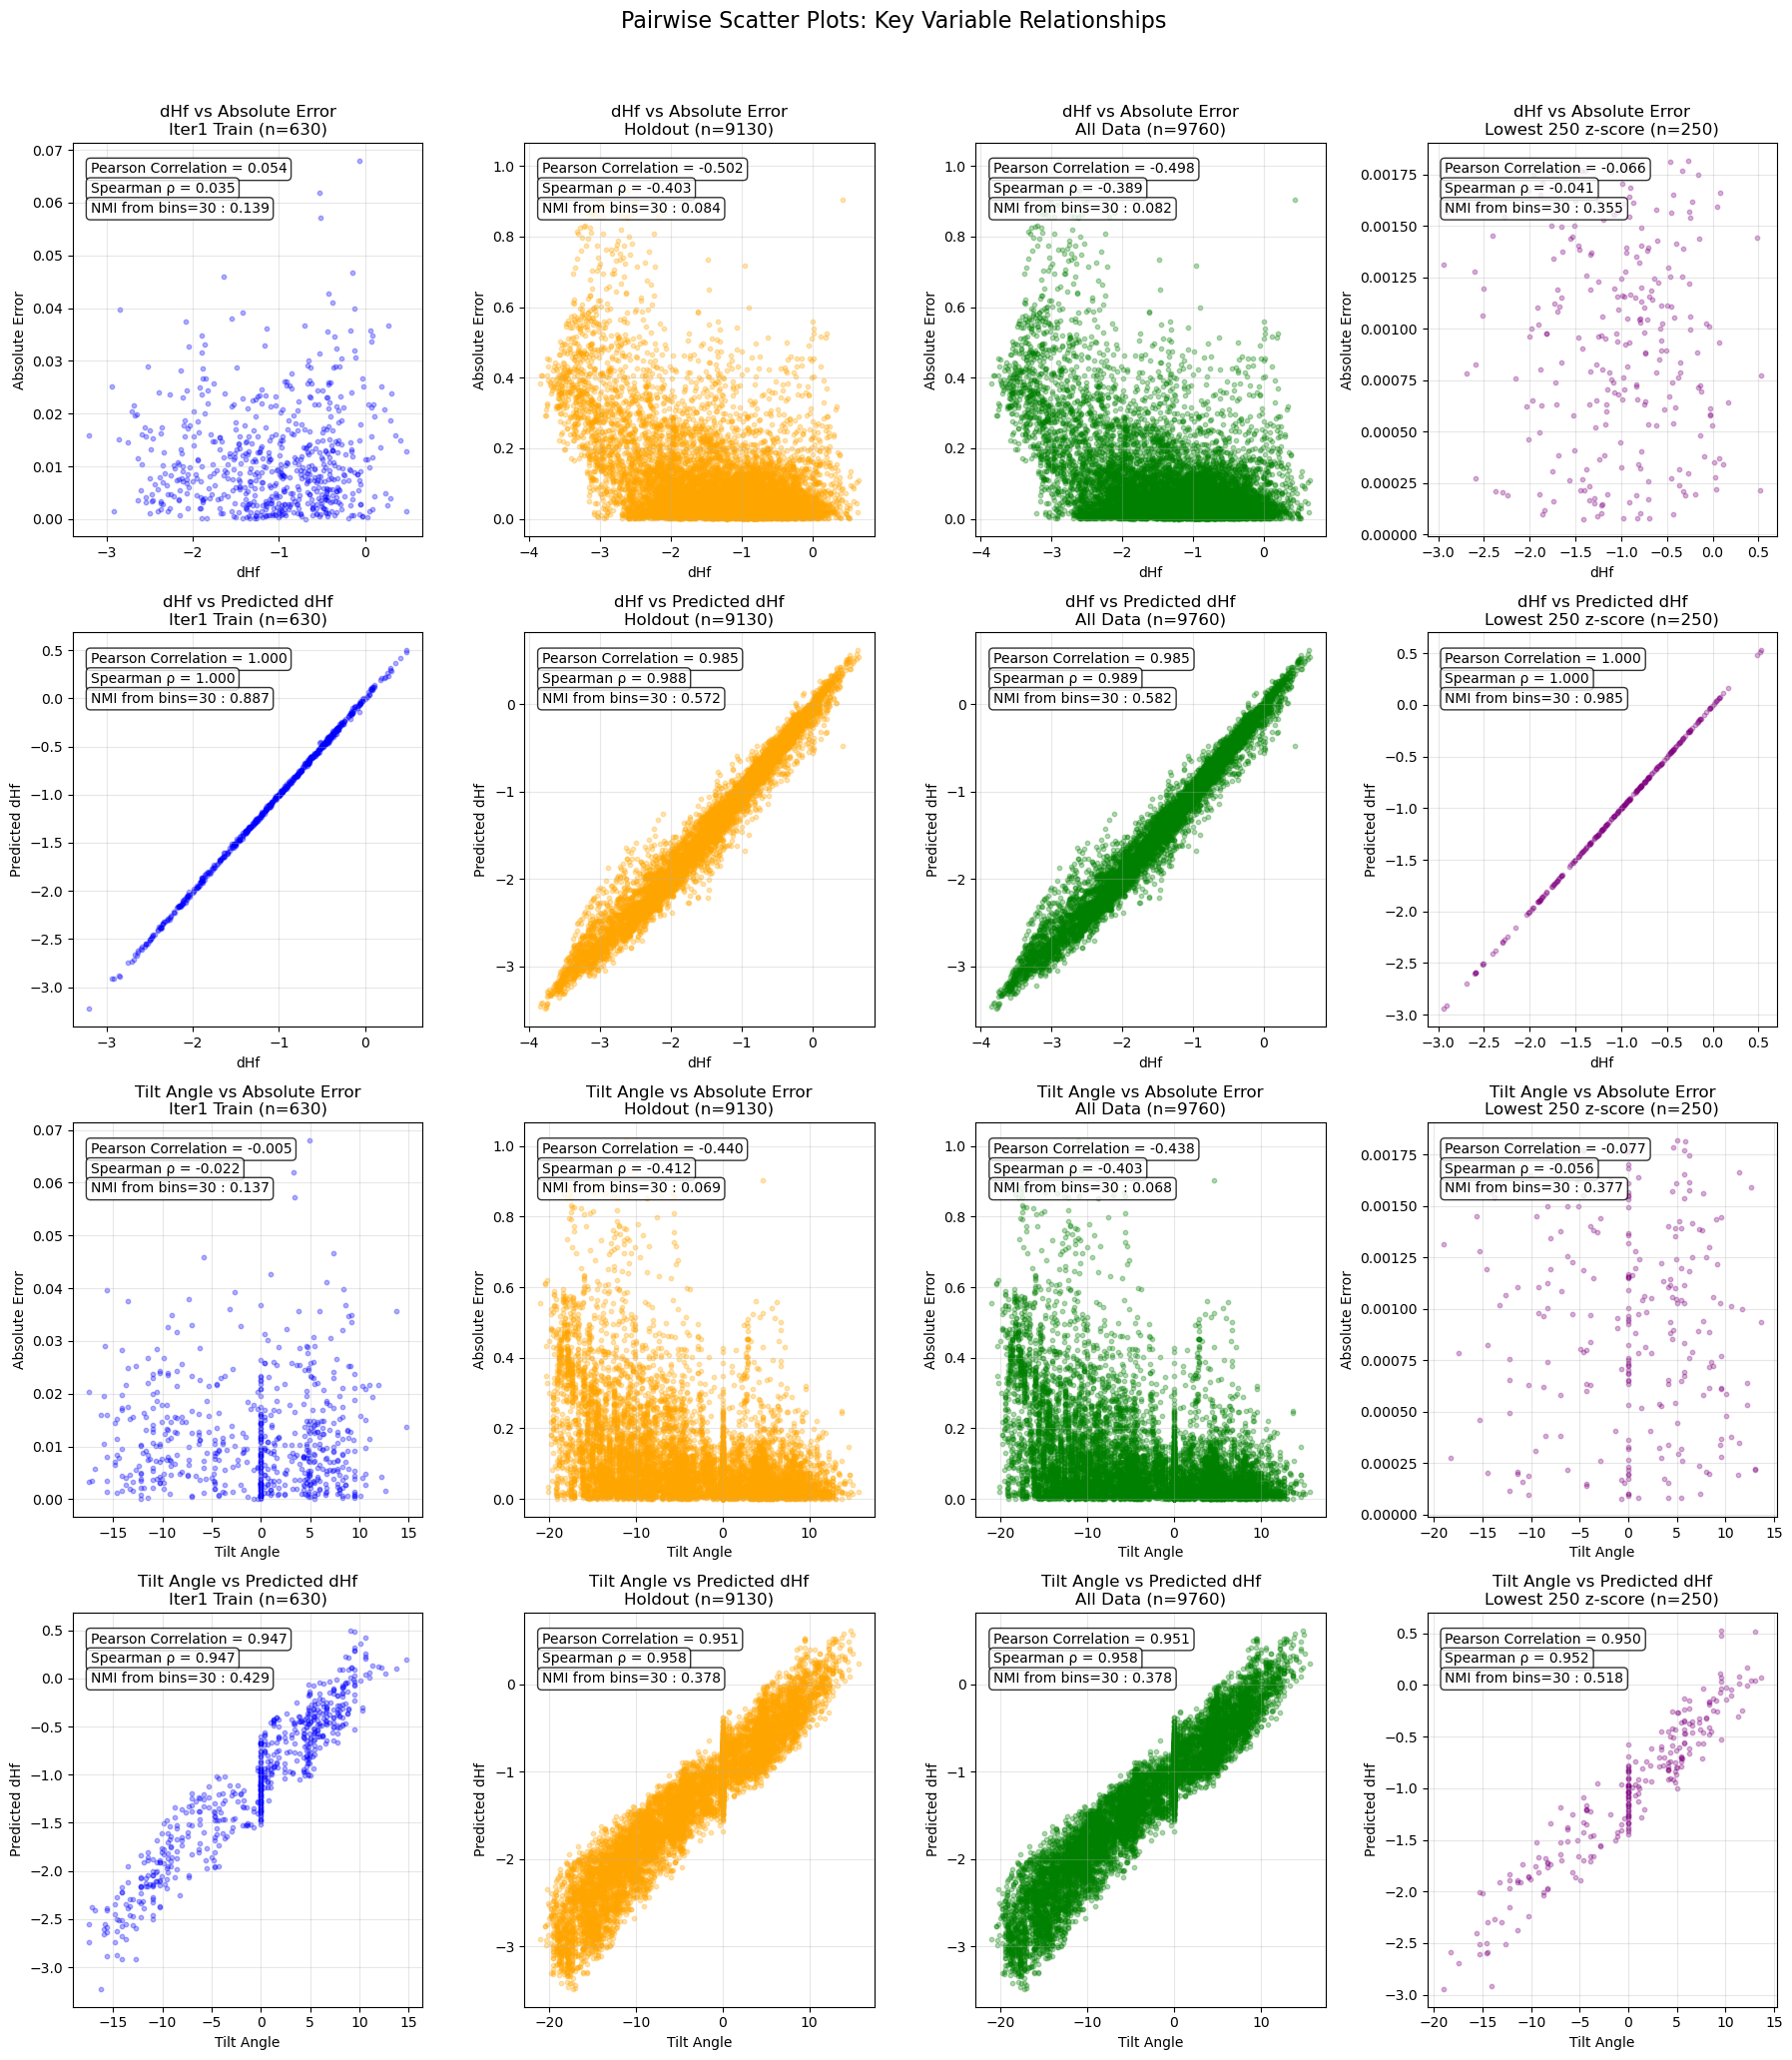

In [29]:
# Create pairwise scatter plots
fig, axes = plt.subplots(4, 4, figsize=(18, 21))

scatter_pairs = [
    ('dHf', 'Absolute Error'),
    ('dHf', 'Predicted dHf'),
    ('Tilt Angle', 'Absolute Error'),
    ('Tilt Angle', 'Predicted dHf')
]

colors = ['blue', 'orange', 'green', 'purple']

for row, (x_label, y_label) in enumerate(scatter_pairs):
    for col, (dataset_name, color) in enumerate(zip(['Iter1 Train', 'Holdout', 'All Data', 'Lowest 250 z-score'], colors)):
        dataset_tuple = datasets[dataset_name]
        
        if row == 0:  # dHf vs Absolute Error
            x_data, y_data = dataset_tuple[0], dataset_tuple[4]
        elif row == 1:  # dHf vs Predicted dHf
            x_data, y_data = dataset_tuple[0], dataset_tuple[2]
        elif row == 2:  # Tilt Angle vs Absolute Error
            x_data, y_data = dataset_tuple[3], dataset_tuple[4]
        else:  # Tilt Angle vs Predicted dHf
            x_data, y_data = dataset_tuple[3], dataset_tuple[2]
        
        if len(x_data) > 0 and len(y_data) > 0:
            axes[row, col].scatter(x_data, y_data, alpha=0.3, color=color, s=10)
            axes[row, col].set_xlabel(x_label)
            axes[row, col].set_ylabel(y_label)
            axes[row, col].set_title(f'{x_label} vs {y_label}\n{dataset_name} (n={len(x_data)})')
            axes[row, col].grid(True, alpha=0.3)
            
            # Add correlation coefficient
            if len(x_data) > 1 and np.var(x_data) > 1e-10 and np.var(y_data) > 1e-10:
                corr = np.corrcoef(x_data, y_data)[0, 1]
                spearman_corr, _ = stats.spearmanr(x_data, y_data)
                axes[row, col].text(0.05, 0.95, f'Pearson Correlation = {corr:.3f}', 
                                   transform=axes[row, col].transAxes, verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                axes[row, col].text(0.05, 0.9, f'Spearman ρ = {spearman_corr:.3f}', 
                                   transform=axes[row, col].transAxes, verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Add NMI score
            # Create mapping for NMI keys based on the scatter plot pairs
            if row == 0:  # dHf vs Z-Score Error
                nmi_key = 'nmi_dhf_zscore'
            elif row == 1:  # dHf vs Predicted dHf
                nmi_key = 'nmi_dhf_pred'
            elif row == 2:  # Tilt Angle vs Z-Score Error
                nmi_key = 'nmi_zscore_angle'
            else:  # Tilt Angle vs Predicted dHf
                nmi_key = 'nmi_pred_angle'
            if nmi_key in nmi_scores[dataset_name]:
                nmi_score = nmi_scores[dataset_name][nmi_key]
                axes[row, col].text(0.05, 0.85, f'NMI from bins=30 : {nmi_score:.3f}', 
                                   transform=axes[row, col].transAxes, verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            axes[row, col].text(0.5, 0.5, 'No data available', ha='center', va='center', 
                               transform=axes[row, col].transAxes)
            axes[row, col].set_title(f'{x_label} vs {y_label}\n{dataset_name}')

plt.suptitle('Pairwise Scatter Plots: Key Variable Relationships', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
